Αλεξανδρής Γιώργος-03118195

Γρηγοριάδου Ναταλία-Μαρία-03118940

Σκόρδα Στεφανία-03118852


# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 
Ημερομηνία εκφώνησης της άσκησης: 29 Νοεμβρίου 2022

**Θα βρείτε το παρόν σε μορφή jupyter notebook ως συνημμένο στο τέλος της εκφώνησης.**


In [1]:
# !pip install --upgrade pip
# !pip install --upgrade numpy
# !pip install --upgrade pandas
# !pip install --upgrade nltk
# !pip install --upgrade scikit-learn
# !pip install --upgrade joblib

In [2]:
import scipy as sp
import pandas as pd
import numpy as np
import os


## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δaουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με 22.301 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [3]:

dataset_url = "https://drive.google.com/uc?export=download&id=1zo13kUAf-MDMPZmBDxq1FxWtZY01lsxD"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

Κάθε ομάδα θα δουλέψει σε **ένα μοναδικό υποσύνολο 5.000 ταινιών** (διαφορετικό dataset για κάθε ομάδα) ως εξής:

1. Κάθε ομάδα του εργαστηρίου νευρωνικών έχει έναν αριθμό στο helios. Θα βάλετε τον αριθμό αυτό στη μεταβλητή team_seed_number στο επόμενο κελί κώδικα.

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [4]:


# Στο επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
team_seed_number = 7

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1g6F4TCHrs2wgtdOk7D3gtONaeirNt_Vo"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus
corpus_df.head()

,0
0,"Alfred is preparing to join the priesthood, bu..."
1,The village of Vileness Flats is constantly un...
2,Last Hurrah for Chivalry is a story about two ...
3,"The film, told almost exclusively through And..."
4,"Amos and Theodore , the old bank robbers turn..."


- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- το dataframe **corpus_df** που είναι απλά το corpus σε μορφή dataframe. Τα summaries βρίσκονται στην κολόνα 0. Πιθανώς να σας βολεύει να κάνετε κάποιες προεπεξεργασίες με dataframes.


Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=999` (την χιλιοστή) θα γράψουμε `print(corpus[999])`.

In [5]:
ID = 999
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

['Hitler']
['"Action",  "Drama",  "Comedy",  "Bollywood"']
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Προεπεξεργασία

Το πρώτο βήμα στην επεξεργασία μας είναι ο καθαρισμός των περιγραφών των ταινιών. 

Εκτυπώστε (αρκετές) διαφορετικές περιγραφές ταινιών για να δείτε πιθανά προβλήματα που θα πρέπει να αντιμετωπιστούν.

Τα (ελάχιστα) βήματα καθαρισμού που προτείνουμε είναι:
- μετατροπή όλων των χαρακτήρων σε πεζά,
- αφαίρεση των stopwords. Εδώ σημειώστε ότι για το δεδομένο task του συστήματος συστάσεων που είναι η πρόταση ταινιών ίσως θα είχαν ενδιαφέρον και λίστες stopwords πέραν αυτών της κοινής γλώσσας.
- αφαίρεση σημείων στίξης και ειδικών χαρακτρήρων (special characters). Αυτό δεν γίνεται μόνο με την punkt του NLTK. Θα μπορούσατε να βασιστείτε σε κανονικές εκφράσεις (regular expressions), και
- αφαίρεση πολυ σύντομων συμβολοσειρών.

Προσοχή: το corpus και τα τελικά tokens που θα το αποτελούν θα χρησιμοποιηθούν στη συνέχεια ως κλειδιά για να βρούμε εμφυτεύματα. Για το λόγο αυτό, πρέπει να είστε προσεκτικοί ως προς την εφαρμογή μεθόδων κανονικοποίησης (text normalization) όπως το stemming και το lemmatization.

In [162]:
#read from file
with open('names.txt', 'r') as f:
    names = f.read().splitlines()
print (type(names))

<class 'list'>


In [208]:
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

new_corpus = corpus.copy()
#read from file
with open('names.txt', 'r') as f:
    names = f.read().splitlines()
names= [x.lower() for x in names]

   

# all to lower case
new_corpus = [x.lower() for x in new_corpus]

# remove stop words
stop_words = set(stopwords.words('english'))
new_corpus = [' '.join([word for word in x.split() if word not in stop_words]) for x in new_corpus]

# remove punctuation
punct = '''!()-[]{}};:'"\,<>./?@#$%^&*_~–“”'''
new_corpus = [''.join([word for word in x if word not in punct]) for x in new_corpus]


# remove all words with length <= 3
new_corpus = [' '.join([word for word in x.split() if len(word) > 3]) for x in new_corpus]

# remove 's annotation for getting only the names and not the references to them
for x in range(len(new_corpus)):
    temp = []
    for w in new_corpus[x].split():
        if('\'s' in w):
            temp.append(w[:-2])
        else:
            temp.append(w)
    new_corpus[x] = ' '.join(temp)

#remove names from corpus
for x in range(len(new_corpus)):
   temp = []
   for w in new_corpus[x].split():
      if(w not in names):
         temp.append(w)
   new_corpus[x] = ' '.join(temp)

# tokenize words
new_corpus_tokens = [word_tokenize(x) for x in new_corpus]


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/natalia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/natalia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:


if os.path.exists("temp.txt"):
    os.remove("temp.txt")

with open("temp.txt","x",encoding="utf8") as f:
    for i in range(5000):
        f.write("{}\n".format(titles[i][0]))

In [8]:
ids_we_know = [1915,272,1989,2687,299,482]

## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [209]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create sparse tf_idf representation
# best try TfidfVectorizer(max_df = 0.0007,min_df=0.0002,stop_words='english')
vectorizer = TfidfVectorizer(max_df = 0.0007,min_df=0.0002,stop_words='english')
vectorizer.fit(new_corpus)
corpus_tf_idf_plain = vectorizer.transform(new_corpus)
corpus_tf_idf = corpus_tf_idf_plain.toarray()

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης.

Προσοχή: ο TfidfVectorizer έχει κάποιες δυνατότητες προεπεξεργασίας παρόποιες με αυτές που αναφέραμε στην προηγούμενη ενότητα. Ό,τι προεπεξεργασία μπορείτε να κάνετε που χρειάζεται ως είσοδο μόνο το κάθε document ξεχωριστά, κάντε την στο πρώτο βήμα της προεπεξεργασίας. Αν χρειάζεται γνώση των συνολικών στατιστικών της συλλογής, κάντε την με τον TfidfVectorizer.

In [210]:
print(corpus_tf_idf_plain.shape)

(5000, 37637)


## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα υλοποιήσετε θα είναι μια συνάρτηση `content_recommender` με τρία ορίσματα: `target_movie`, `max_recommendations` και `corpus_type`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, θα υπολογίζετε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας όπως αυτές αναπαριστώνται στο `corpus_type`.
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), ομοιότητα συνημιτόνου, id, τίτλο, σύνοψη, και κατηγορίες (categories)


In [211]:
def movie_info(id):
    print("ID : {}".format(id))
    print("Title : {}".format(*titles[id]))
    print("Corpus : {}".format(corpus[id]))
    print("Categories : {}".format(*categories[id]))

def cos_sim(A,B):

    if np.linalg.norm(A) == 0.0 or np.linalg.norm(B) == 0.0: 
        return 0.0
    
    temp = np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B))

    return np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B))




def content_recommender(target_movie,max_recommendations,corpus_type):
    
    mymov = corpus_type[target_movie]

    similarities = [(i,cos_sim(mymov,corpus_type[i])) for i in range(len(corpus_type))]
    similarities = sorted(similarities,reverse=True,key = lambda t : t[1])
    

    #
    # print(similarities)

    print("FOR TARGET MOVIE :")
    movie_info(target_movie)
    print("--------------------")
    print("RECOMMENDATIONS :")
    for i in range(1,max_recommendations+1):
        print("No. {}\nSimilarity: {}".format(i,similarities[i][1]))
        movie_info(similarities[i][0])
        print("--------------------")



## Βελτιστοποίηση του TfidfVectorizer

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε την για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. 

Ταυτόχρονα, μια αντίρροπη κατά κάποιο τρόπο κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




In [212]:
vectorizer1 = TfidfVectorizer(max_df = 0.0007,min_df=0.0002,stop_words='english')
vectorizer2 = TfidfVectorizer(max_df = 0.9,min_df=0.1,stop_words='english')
vectorizer3 = TfidfVectorizer(max_df = 0.5,min_df=0.01,stop_words='english')
vectorizer4 = TfidfVectorizer(max_df = 0.3,min_df=0.002,stop_words='english')

vectorizer5 = TfidfVectorizer(max_df = 0.1,min_df=0.0005,stop_words='english')

## Δοκιμή 1

In [213]:
vectorizer1.fit(new_corpus)
corpus_tf_idf_plain_1 = vectorizer1.transform(new_corpus)
corpus_tf_idf_1 = corpus_tf_idf_plain_1.toarray()

In [214]:
print("SHAPE -> {}".format(corpus_tf_idf_plain_1.shape))
content_recommender(3170,2,corpus_tf_idf_1)
content_recommender(2922,2,corpus_tf_idf_1)

SHAPE -> (5000, 37637)
FOR TARGET MOVIE :
ID : 3170
Title : Superman
Corpus : On the planet Krypton, using evidence provided by scientist Jor-El, the Ruling Council sentences three attempted insurrectionists, General Zod, Ursa and Non, to "eternal living death" in the Phantom Zone. Despite his eminence, Jor-El is unable to convince the Council of his belief that Krypton will soon explode. To save his infant son Kal-El, Jor-El launches a spacecraft containing the child towards Earth, a distant planet with a suitable atmosphere, and where Kal-El's dense molecular structure will give him superhuman powers. Shortly after the launch, Krypton is destroyed. Three years later the ship lands near an American farming town, Smallville, where Kal-El is found by Jonathan and Martha Kent. The Kents take the child back to their farm and raised him as their own son, naming him Clark after Martha's maiden name. At age 18, soon after the death of Jonathan, Clark hears a psychic "call", discovering a glo

## Δοκιμή 2


In [215]:

vectorizer2.fit(new_corpus)
corpus_tf_idf_plain_2 = vectorizer2.transform(new_corpus)
corpus_tf_idf_2 = corpus_tf_idf_plain_2.toarray()
print("SHAPE -> {}".format(corpus_tf_idf_plain_2.shape))
content_recommender(3170,2,corpus_tf_idf_2)
content_recommender(2922,2,corpus_tf_idf_2)

SHAPE -> (5000, 81)
FOR TARGET MOVIE :
ID : 3170
Title : Superman
Corpus : On the planet Krypton, using evidence provided by scientist Jor-El, the Ruling Council sentences three attempted insurrectionists, General Zod, Ursa and Non, to "eternal living death" in the Phantom Zone. Despite his eminence, Jor-El is unable to convince the Council of his belief that Krypton will soon explode. To save his infant son Kal-El, Jor-El launches a spacecraft containing the child towards Earth, a distant planet with a suitable atmosphere, and where Kal-El's dense molecular structure will give him superhuman powers. Shortly after the launch, Krypton is destroyed. Three years later the ship lands near an American farming town, Smallville, where Kal-El is found by Jonathan and Martha Kent. The Kents take the child back to their farm and raised him as their own son, naming him Clark after Martha's maiden name. At age 18, soon after the death of Jonathan, Clark hears a psychic "call", discovering a glowin

## Δοκιμή 3

In [216]:
vectorizer3.fit(new_corpus)
corpus_tf_idf_plain_3 = vectorizer3.transform(new_corpus)
corpus_tf_idf_3 = corpus_tf_idf_plain_3.toarray()
print("SHAPE -> {}".format(corpus_tf_idf_plain_3.shape))
content_recommender(3170,5,corpus_tf_idf_3)
content_recommender(2922,5,corpus_tf_idf_3)

SHAPE -> (5000, 1933)
FOR TARGET MOVIE :
ID : 3170
Title : Superman
Corpus : On the planet Krypton, using evidence provided by scientist Jor-El, the Ruling Council sentences three attempted insurrectionists, General Zod, Ursa and Non, to "eternal living death" in the Phantom Zone. Despite his eminence, Jor-El is unable to convince the Council of his belief that Krypton will soon explode. To save his infant son Kal-El, Jor-El launches a spacecraft containing the child towards Earth, a distant planet with a suitable atmosphere, and where Kal-El's dense molecular structure will give him superhuman powers. Shortly after the launch, Krypton is destroyed. Three years later the ship lands near an American farming town, Smallville, where Kal-El is found by Jonathan and Martha Kent. The Kents take the child back to their farm and raised him as their own son, naming him Clark after Martha's maiden name. At age 18, soon after the death of Jonathan, Clark hears a psychic "call", discovering a glow

## Δοκιμή 4

In [217]:
vectorizer4.fit(new_corpus)
corpus_tf_idf_plain_4 = vectorizer4.transform(new_corpus)
corpus_tf_idf_4 = corpus_tf_idf_plain_4.toarray()
print("SHAPE -> {}".format(corpus_tf_idf_plain_4.shape))
content_recommender(3170,10,corpus_tf_idf_4)
content_recommender(2922,10,corpus_tf_idf_4)

SHAPE -> (5000, 7187)
FOR TARGET MOVIE :
ID : 3170
Title : Superman
Corpus : On the planet Krypton, using evidence provided by scientist Jor-El, the Ruling Council sentences three attempted insurrectionists, General Zod, Ursa and Non, to "eternal living death" in the Phantom Zone. Despite his eminence, Jor-El is unable to convince the Council of his belief that Krypton will soon explode. To save his infant son Kal-El, Jor-El launches a spacecraft containing the child towards Earth, a distant planet with a suitable atmosphere, and where Kal-El's dense molecular structure will give him superhuman powers. Shortly after the launch, Krypton is destroyed. Three years later the ship lands near an American farming town, Smallville, where Kal-El is found by Jonathan and Martha Kent. The Kents take the child back to their farm and raised him as their own son, naming him Clark after Martha's maiden name. At age 18, soon after the death of Jonathan, Clark hears a psychic "call", discovering a glow

In [218]:
content_recommender(1809,10,corpus_tf_idf_4)

FOR TARGET MOVIE :
ID : 1809
Title : Sniper 2
Corpus : Former U.S. Marine Corps scout sniper Thomas Beckett , who was discharged after his finger was amputated in the first film, is met by CIA officer James Eckles  and Colonel David McKenna  at his home in Montana. Despite losing his index finger he uses to shoot, Beckett still has the capability of firing a gun . Considering this, along with his impressive career from his time in the Marine Corps, Beckett is given a mission to assassinate renegade Serbian General Mile Valstoria , who is responsible for conducting hit-and-run ethnic cleansing operations in Muslim-populated areas in Serbia. The CIA fears that Valstoria's actions are threatening to inflame a larger conflict in the region. Given the details of the mission, Beckett requests that an additional man, a spotter, must come with him. At the U.S. embassy in Berlin, Beckett is introduced to his spotter, Jake Cole , an experienced U.S. Army sniper who is on death row for killing a 

## Δοκιμή 5

In [219]:
vectorizer5.fit(new_corpus)
corpus_tf_idf_plain_5 = vectorizer5.transform(new_corpus)
corpus_tf_idf_5 = corpus_tf_idf_plain_5.toarray()
print("SHAPE -> {}".format(corpus_tf_idf_plain_5.shape))
content_recommender(3170,10,corpus_tf_idf_5)
content_recommender(2922,10,corpus_tf_idf_5)

SHAPE -> (5000, 16591)
FOR TARGET MOVIE :
ID : 3170
Title : Superman
Corpus : On the planet Krypton, using evidence provided by scientist Jor-El, the Ruling Council sentences three attempted insurrectionists, General Zod, Ursa and Non, to "eternal living death" in the Phantom Zone. Despite his eminence, Jor-El is unable to convince the Council of his belief that Krypton will soon explode. To save his infant son Kal-El, Jor-El launches a spacecraft containing the child towards Earth, a distant planet with a suitable atmosphere, and where Kal-El's dense molecular structure will give him superhuman powers. Shortly after the launch, Krypton is destroyed. Three years later the ship lands near an American farming town, Smallville, where Kal-El is found by Jonathan and Martha Kent. The Kents take the child back to their farm and raised him as their own son, naming him Clark after Martha's maiden name. At age 18, soon after the death of Jonathan, Clark hears a psychic "call", discovering a glo

In [220]:
content_recommender(1809,10,corpus_tf_idf_5)

FOR TARGET MOVIE :
ID : 1809
Title : Sniper 2
Corpus : Former U.S. Marine Corps scout sniper Thomas Beckett , who was discharged after his finger was amputated in the first film, is met by CIA officer James Eckles  and Colonel David McKenna  at his home in Montana. Despite losing his index finger he uses to shoot, Beckett still has the capability of firing a gun . Considering this, along with his impressive career from his time in the Marine Corps, Beckett is given a mission to assassinate renegade Serbian General Mile Valstoria , who is responsible for conducting hit-and-run ethnic cleansing operations in Muslim-populated areas in Serbia. The CIA fears that Valstoria's actions are threatening to inflame a larger conflict in the region. Given the details of the mission, Beckett requests that an additional man, a spotter, must come with him. At the U.S. embassy in Berlin, Beckett is introduced to his spotter, Jake Cole , an experienced U.S. Army sniper who is on death row for killing a 

In [221]:
content_recommender(1989,10,corpus_tf_idf_4)

FOR TARGET MOVIE :
ID : 1989
Title : Pokémon: Lucario and the Mystery of Mew
Corpus : In the legendary past, before Poké Balls were made, an aura-guiding hero Pokémon named Lucario sensed two armies about to clash at Cameron Palace in Kanto. He told his master, Sir Aaron, while he was being attacked by a group of Houndoom. During the battle, Lucario was blinded, and he used his Aura Sphere to eliminate the Houndoom. The Queen of Cameron, Lady Rin, decided to die with her people, and so Aaron got on his Pidgeot and traveled to the Tree of Beginning, but they were attacked by a rival group of Skarmory. Later, Lucario arrived by sensing his master’s Aura. Sir Aaron forbade Lucario from calling him “Master” anymore and admitted he has abandoned the Queen. He then swore never to return and headed to the Tree of Beginning. Lucario tried to go with him, but Aaron sealed Lucario in his staff. Pidgeot visited the queen with only Sir Aaron’s staff, and the queen realized that Sir Aaron sacrifice

In [222]:
content_recommender(1989,10,corpus_tf_idf_5)

FOR TARGET MOVIE :
ID : 1989
Title : Pokémon: Lucario and the Mystery of Mew
Corpus : In the legendary past, before Poké Balls were made, an aura-guiding hero Pokémon named Lucario sensed two armies about to clash at Cameron Palace in Kanto. He told his master, Sir Aaron, while he was being attacked by a group of Houndoom. During the battle, Lucario was blinded, and he used his Aura Sphere to eliminate the Houndoom. The Queen of Cameron, Lady Rin, decided to die with her people, and so Aaron got on his Pidgeot and traveled to the Tree of Beginning, but they were attacked by a rival group of Skarmory. Later, Lucario arrived by sensing his master’s Aura. Sir Aaron forbade Lucario from calling him “Master” anymore and admitted he has abandoned the Queen. He then swore never to return and headed to the Tree of Beginning. Lucario tried to go with him, but Aaron sealed Lucario in his staff. Pidgeot visited the queen with only Sir Aaron’s staff, and the queen realized that Sir Aaron sacrifice

In [223]:
content_recommender(2687,10,corpus_tf_idf_4)

FOR TARGET MOVIE :
ID : 2687
Title : Pokémon: Destiny Deoxys
Corpus :  A mysterious meteorite is hurtling towards the earth. During its entry into the atmosphere, it almost wounds Rayquaza, a sky guardian living in the ozone layer. The meteorite crashes into a polar zone, revealing two egg-shaped objects. The purple egg regenerates into a Deoxys and picks up the green egg. Rayquaza descends from the ozone layer to fight the invader. A battle ensues, destroying a nearby research site and traumatizing a young boy, scared by a stampede of Spheal, Sealeo, and Walrein. The purple Deoxys traps Rayquaza and is about to beat it, but it is distracted by electricity from broken computers, giving Rayquaza a chance to obliterate the purple Deoxys with its Hyper Beam. Deoxys goes back to egg form and falls into the sea, while some researchers take the green egg with them. Beneath the sea, the injured Deoxys regenerates and waits. The green egg appears somewhere in Hoenn. Four years later, Ash, May,

In [224]:
content_recommender(1809,10,corpus_tf_idf_4)

FOR TARGET MOVIE :
ID : 1809
Title : Sniper 2
Corpus : Former U.S. Marine Corps scout sniper Thomas Beckett , who was discharged after his finger was amputated in the first film, is met by CIA officer James Eckles  and Colonel David McKenna  at his home in Montana. Despite losing his index finger he uses to shoot, Beckett still has the capability of firing a gun . Considering this, along with his impressive career from his time in the Marine Corps, Beckett is given a mission to assassinate renegade Serbian General Mile Valstoria , who is responsible for conducting hit-and-run ethnic cleansing operations in Muslim-populated areas in Serbia. The CIA fears that Valstoria's actions are threatening to inflame a larger conflict in the region. Given the details of the mission, Beckett requests that an additional man, a spotter, must come with him. At the U.S. embassy in Berlin, Beckett is introduced to his spotter, Jake Cole , an experienced U.S. Army sniper who is on death row for killing a 

In [225]:
content_recommender(1809,10,corpus_tf_idf_5)

FOR TARGET MOVIE :
ID : 1809
Title : Sniper 2
Corpus : Former U.S. Marine Corps scout sniper Thomas Beckett , who was discharged after his finger was amputated in the first film, is met by CIA officer James Eckles  and Colonel David McKenna  at his home in Montana. Despite losing his index finger he uses to shoot, Beckett still has the capability of firing a gun . Considering this, along with his impressive career from his time in the Marine Corps, Beckett is given a mission to assassinate renegade Serbian General Mile Valstoria , who is responsible for conducting hit-and-run ethnic cleansing operations in Muslim-populated areas in Serbia. The CIA fears that Valstoria's actions are threatening to inflame a larger conflict in the region. Given the details of the mission, Beckett requests that an additional man, a spotter, must come with him. At the U.S. embassy in Berlin, Beckett is introduced to his spotter, Jake Cole , an experienced U.S. Army sniper who is on death row for killing a 

In [226]:
print("SHAPE -> {}".format(corpus_tf_idf_plain_5.shape))

SHAPE -> (5000, 16591)


In [227]:
content_recommender(894,10,corpus_tf_idf_5)

FOR TARGET MOVIE :
ID : 894
Title : Superman II
Corpus :  Prior to the destruction of Krypton, the criminals General Zod , Ursa  and Non  are sentenced by Jor-El to banishment into the Phantom Zone for insurrection, among other crimes. After traveling through the galaxy for many years, the Phantom Zone is shattered near Earth by the shockwave from the harmless detonation of a hydrogen bomb, which had been launched into space by Superman  after foiling a terrorists' plot to blow up Paris. The three Kryptonian criminals are freed from the Zone, finding themselves with super-powers granted by the yellow light of Earth's sun. After attacking human astronauts on the moon and the small town of East Houston, Idaho , the three travel to the White House and force the President of the United States  to surrender to Zod on behalf of the entire planet during an international television broadcast. When the President pleads for Superman to save the Earth, Zod recognizes Superman as "the son of our j

In [228]:
content_recommender(482,10,corpus_tf_idf_5)

FOR TARGET MOVIE :
ID : 482
Title : Barbie and the Magic of Pegasus
Corpus : In a magical kingdom, the Queen wants to surprise her daughter, Princess Annika, with a birthday gift. When she opens the door to Annika's room, she discovers that Annika is missing, having gone to an ice rink without asking for permission. Out skating, Annika meets a small polar bear whom she names Shiver. When Annika returns to the palace, her parents are so worried and overprotective they forbid her from skating ever again. That night, Annika sneaks out of the palace to join a festival. A powerful wizard named Wenlock appears and asks the princess to marry him. When Annika refuses, Wenlock furiously tells the king and queen the fate of their "other daughter," which surprises Annika. Wenlock magically turns everyone into stone, but Annika is saved by Brietta, a flying horse, but Wenlock tells her that she has three days to marry him, otherwise the spell will be permanent. Brietta takes Annika to a castle in 

## Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

Η προσέγγιση της κατασκευής μόνο μέσω tfidf του συστήματος συστάσεων έχει διάφορα μειονεκτήματα. Θα μας ενδιέφερε λοιπόν να δούμε αν μπορούμε να χρησιμοποιήσουμε για τις λέξεις **εμφυτεύματα (embeddings)**, δηλαδή τις πυκνές διανυσματικές αναπαραστάσεις για τις λέξεις που μας δίνει το μοντέλο **Word2Vec**

Ωστόσο, το dataset της κάθε ομάδας είναι πολύ μικρό για να εξάγουμε τα δικά μας word embeddings (και να είναι καλά). Για το λόγο αυτό θα χρησιμοποιήσουμε τη μεθοδολογία της Βαθιάς Μάθησης που είναι η **Μεταφορά Μάθησης (Transfer Learning).**.

Στη μεταφορά μάθησης ουσιαστικά μεταφέρουμε τη γνώση που έχει αποκτήσει ένα ήδη εκπαιδευμένο (και κατά κανόνα πολύ μεγάλο) σύστημα. Η μεταφορά γίνεται διαμέσου των τιμών των βαρών που έχει προσδιορίσει μετά το πέρας της εκπαίδευσης.

Στην περίπτωσή μας, δεν μας ενδιαφέρουν τόσο τα ίδια τα βάρη των μοντέλων από τα οποία θα κάνουμε μεταφορά μάθησης. Κάτι τέτοιο θα μας ενδιέφερε αν π.χ. θέλαμε να συνεχίσουμε την εκπαίδευση στα δικά μας κείμενα. Μας ενδιαφέρουν όμως τα ίδια τα εμφυτεύματα, δηλαδή τα embeddings (διανύσματα διαστάσεων $m$) που έχει μάθει το νευρωνικό για το λεξιλόγιο του (vocabulary). To vocabulary σε τέτοια μεγάλα νευρωνικά θα είναι πιθανότατα υπερσύνολο του δικού μας.

### Μεταφορά μάθησης εμφυτευμάτων



#### Εμφυτεύματα του Gensim-data
Το Gensim περιλαμβάνει αρκετά προεκπαιδευμένα μοντέλα εμφυτευμάτων Word2Vec. Με το επόμενο κελί παίρνουμε τη λίστα τους.

In [229]:
!pip install -U gensim
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

Defaulting to user installation because normal site-packages is not writeable
['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Τα μοντέλα αυτά βρίσκονται στο [αποθετήριο Gensim-data](https://github.com/RaRe-Technologies/gensim-data) όπου μπορείτε να βρείτε και την τεκμηρίωσή τους. Η φόρτωση των μοντέλων αυτών γίνεται με τη συνάρτηση `gensim.downloader.load`.

#### Άλλα εμφυτεύμαατα
Μπορείτε να βρείτε προεκπαιδευμένα εμφυτεύματα και από πηγές εκτός του Gensim. Για παράδειγμα:

- [Google News dataset](https://code.google.com/archive/p/word2vec/). Πρόκειται για προ-εκπαιδευμένα διανύσματα που έχουν εκπαιδευτεί σε μέρος του συνόλου δεδομένων Google News (περίπου 100 δισεκατομμύρια λέξεις). Το μοντέλο περιέχει διανύσματα 300 διαστάσεων για 3 εκατομμύρια λέξεις και φράσεις.
- [Amazon BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html). Το BlazingText δεν είναι μόνο προεκπαιδευμένα εμφυτεύματα αλλα και βελτιστοποιημένες υλοποιήσεις των αλγορίθμων Word2vec για την επεξεργασία κειμένου. Προυπόθεση είναι να δουλέψει κανείς στο SageMaker.

Οι διαδικασίες φόρτωσης embeddings από εξωτερικά δεδομένα μπορεί να είναι ελαφρά διαφορετικές από αυτή του Gensim.



#### Παρατηρήσεις

*   Επαναλαμβάνουμε ότι στην εργασία αυτή δεν μας ενδιαφέρουν τα ίδια τα μοντέλα αλλά το να μπορούμε για μία λέξη του λεξιλογίου μας να μπορούμε να βρούμε το embedding (διάνυσμα) που της αντιστοιχεί στο εκάστοτε προεκπαιδευμένο μοντέλο. 

*   Επίσης, δεν θα χρησιμοποιήσουμε την `Phrases` για να βρούμε bigrams στο dataset μας όπως θα ήταν το ορθότερο, καθώς αυτό θα απαιτούσε την συνέχιση της εκπαίδευσης του μοντέλου σε νέο λεξιλόγιο με πολύ λίγα νέα δεδομένα.


 ### Δημιουργία corpora βασισμένων στα εμφυτεύματα

Για να μπορέσουμε να ενσωματώσουμε τη γνώση που υπάρχει στα προεκπαιδευμένα εμφυτεύματα στο δικό μας corpus θα προχωρήσουμε όπως περιγράφεται ακολούθως.

Για κάθε περιγραφή ταινίας $d$, η οποία αποτελείται από τις $N_d$ λέξεις $w_i$, το  $tfidf$ της κάθε λέξης $w_i$ δίνεται από τη σχέση:

$$ tfidf(w_i) = tf(w_i,d) \cdot idf(w_i)$$

Ταυτόχρονα, σε κάθε λέξη $w_i$ αντιστοιχεί ένα διάνυσμα $W2V(w_i)$ από το μοντέλο εμφυτευμάτων που έχουμε εισάγει. Τα διανύσματα εμφυτευμάτων $W2V$ θα έχουν διάσταση $m$, ανάλογα το μοντέλο. 

Για κάθε ταινία d, μπορούμε να δημιουργήσουμε μια διανυσματική αναπαράσταση $W2V(d)$ διαστάσεων $m$ χρησιμοποιώντας το $tfidf(w_i)$ ως συντελεστή βαρύτητας για κάθε εμφύτευμα $W2V(w_i)$:

$$ W2V(d) = \frac{tfidf(w_1)\cdot W2V(w_i) + tfidf(w_2)\cdot W2V(w_2) + \dotsc  + tfidf(w_{N_{d}})\cdot W2V(w_{N_{d}})}{tfidf(w_1)+tfidf(w_2)+ \dotsc + tfidf(w_{N_{d}})}$$


#### build_tfw2v

Υλοποιήστε μια συνάρτηση `build_tfw2v` με ορίσματα:
- `corpus` που θα είναι το προεπεξεργασμένο dataset σας,
- `vectors` που θα είναι το μοντέλο που θα σας δίνει τα διανύσματα των εμφυτεύσεων vectors, και 
- `embeddings_size` που θα είναι η διάσταση των εμφυτευμάτων $m$.

H συνάρτηση αυτή θα επιστρέφει ένα νέο corpus που θα είναι ένας πίνακας 5000 (όσες οι ταινίες σας) x $m$ (το η διάσταση των εμφυτευμάτων). Ανάλογα ποιο μοντέλο χρησιμποιείτε για transfer learning ο πίνακας αυτός θα είναι διαφορετικός.

Μπορείτε πλεόν να καλείτε την `content_recommender` με διαφορετικά corpora στο όρισμα `corpus_type`. Σημειώστε ότι στο TFidfVectorizer χρησιμοποιουμε τη σειριακή μορφή των numpy arrays και ίσως σας χρησιμεύσει η `sparse.csr_matrix()` από την Scipy.

In [249]:
def build_tfw2v(corpus,vectors,embeddings_size):
    vectorizer = TfidfVectorizer(max_df = 0.1,min_df=0.0005,stop_words='english')
    vectorizer.fit(corpus)
    corpus_tf_idf_plain = vectorizer.transform(corpus)
    corpus_tf_idf = corpus_tf_idf_plain.toarray()

    tfw2v = np.zeros((len(corpus),embeddings_size))

    for i,c in enumerate(corpus):
        temp = 0
        for w in c.split(' '):
            try:
                tfw2v[i] += corpus_tf_idf[i][vectorizer.vocabulary_[w]] * vectors[w]
            except:
                tfw2v[i] += 0
            
            try:
                temp += corpus_tf_idf[i][vectorizer.vocabulary_[w]]
            except:
                temp += 0

        if(temp == 0):
            tfw2v[i] = 100000000
        else:
            tfw2v[i] /= temp
    
    return np.array(tfw2v)



## Ανάλυση αποτελεσμάτων

### Σύστημα συστάσεων βασισμένο μόνο στο tfidf

- Σε markdown περιγράψτε τι προεπεξεργασία κάνετε στα κείμενα και γιατί.

- Περιγράψτε πως προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. 

- [Cherry-picking:](https://www.wikiwand.com/en/Cherry_picking) Δώσετε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (τουλάχιστον 5) και σχολιάστε.

- [Nit-picking:](https://en.wikipedia.org/wiki/Nitpicking) Δώστε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν κακά αποτελέσματα και σχολιάστε.

- Ποια είναι συνολικά τα πλεονεκτήματα και μειονεκτήματα ενός recommender βασισμένου στο tfidf;

### ΣΧΟΛΙΑΣΜΟΣ 
* Με βάση και την εκφώνηση, τα βήματα προεπεξεργασίας που αποκολουθήσαμε είναι τα εξής: 
    * Μετατρέψαμε όλα τα γράμματα σε πεζά 
    * Αφαιρέσαμε όλα τα σημεία στίξης και το κτητικό ('s) ώστε οι λέξεις να εστιάζουν αποκλειστικά στα ονόματα και όχι στις κτητικές αναφορές επί αυτών
    * Έπειτα από δοκιμές, παρατηρήσαμε ότι τα ονόματα των χαρακτήρων σε κάποιες ταινίες έπαιζαν καθοριστικό ρόλο στις προτάσεις ταινιών, παρόλο που οι ταινίες δεν είχαν κάποια άλλη συσχέτηση μεταξύ τους, οπότε αφαιρέσαμε από τις περιγραφές των ταινιών τα ονόματα.
    * Αφαιρέσαμε όλα τα stopwords από την βιβλιοθήκη nltk
    * Τέλος, αφαιρέσαμε και όλες τις λέξεις με μήκος μικρότερο ή ίσο του 3 προκειμένου να μην επηρρεάζουν στην τελική απόφαση λέξεις όπως άρθρα κτλ.
* Αρχικά, επιλέξαμε να εξετάσουμε ταινίες που να γνωρίζουμε και είδαμε ότι υπάρχουν σε πολλές εκδοχές (πχ superman, barbie,pokemon και sniper). Με δοκιμές αλλάζοντας τις παραμέτρους max_df/min_df καταλήξαμε ότι οι βέλτιστες τιμές για τις παραμέτρους αυτές είναι 0.1,0.0005 αντίστοιχα.
* Cherry-picking:  οι ταινίες που επιλέχθησαν για cherry-picking είναι Superman και Snipper 2 και τα αποτελέσματά τους παρατίθενται παρακάτω. Βλέπουμε ότι όντως οι ταινίες που προτείνει είναι κοντινές με τις αρχικές καθώς πρώτη πρόταση και για τις δύο είναι ταινίες της ίδιας σειράς αλλά καοι οι υπόλοιπες προτάσεις είναι αρκετά σχετικές ως προς την περιγραφή τους.
* Nit-picking:  οι ταινίες που επιλέχθησαν για nit-picking είναι η Barbie Mariposa και τα αποτελέσματά τους παρατίθενται παρακάτω. Βλέπουμε ότι σε αυτή την περίπτωση οι ταινίες-προτάσεις είναι σε αρκετά διαφορετική θεματολογία σε σχέση με την αρχική, καθώς η ταινία αναφέρεται κυρίως σε παιδιά και σε κινούμενα σχέδια και από τις πρώτες πιο κοντινές εκτιμήσεις είναι ταινίες τρόμου και θρίλλερ.
* Πλεονεκτήματα: 
  * Το σύστημα μας είναι απλό και εύκολο στην χρήση. 
  * Επειδή βασίζεται στις λέξεις-κλειδιά των περιγραφών είναι αρκετά αποτελεσματικό στο να βρίσκει ταινίες που ανήκουν στην ιδια σειρά ταινιών, αν περιέχουν επαναλήψεις ονομάτων, ιδιοτήτων και γεγονότων. 
* Μειονεκτήματα:
  * Το σύστημα μας δεν είναι αρκετά αποτελεσματικό στο να βρίσκει ταινίες που ανήκουν στην ίδια κατηγορία, αν δεν περιέχουν τις λέξεις-κλειδιά που αναφέρονται στην κατηγορία. Για παράδειγμα, αν η ταινία περιέχει λέξεις όπως "πολέμος", "αντιπολίτευση", "πολιτική" μπορεί να αναφέρεται σε μια ταινία πολέμου ή σε μια ταινία πολιτικής κωμωδίας.
  * Δεν μπορεί να ανιχνεύσει συνώνυμες εννοιολογικά λέξεις. Για παράδειγμα, μια ταινία που περιέχει την λέξη Χριστούγεννα δεν αναγνωρίζεται ως συναφής με μία που περιέχει την λέξη Αη-Βασίλης.
  * Το μήκος της περιγραφής επηρρεάζει στην επιλογή των βαρών των λέξεων άρα και των ταινιών. Επομένως, το αν μια περιγραφή είναι επιγραμματική ή πιο αναλυτική επηρρεάζει τις προτάσεις του συστήματος.

## Cherry-picking tf-idf
Παραδείγματα cherry picking με τις αντίστοιχες εξόδους.

##### Superman (ID: 3170)

In [250]:
#superman
content_recommender(3170,5,corpus_tf_idf_5)

FOR TARGET MOVIE :
ID : 3170
Title : Superman
Corpus : On the planet Krypton, using evidence provided by scientist Jor-El, the Ruling Council sentences three attempted insurrectionists, General Zod, Ursa and Non, to "eternal living death" in the Phantom Zone. Despite his eminence, Jor-El is unable to convince the Council of his belief that Krypton will soon explode. To save his infant son Kal-El, Jor-El launches a spacecraft containing the child towards Earth, a distant planet with a suitable atmosphere, and where Kal-El's dense molecular structure will give him superhuman powers. Shortly after the launch, Krypton is destroyed. Three years later the ship lands near an American farming town, Smallville, where Kal-El is found by Jonathan and Martha Kent. The Kents take the child back to their farm and raised him as their own son, naming him Clark after Martha's maiden name. At age 18, soon after the death of Jonathan, Clark hears a psychic "call", discovering a glowing green crystal in t

In [251]:
content_recommender(1809,5,corpus_tf_idf_4)

FOR TARGET MOVIE :
ID : 1809
Title : Sniper 2
Corpus : Former U.S. Marine Corps scout sniper Thomas Beckett , who was discharged after his finger was amputated in the first film, is met by CIA officer James Eckles  and Colonel David McKenna  at his home in Montana. Despite losing his index finger he uses to shoot, Beckett still has the capability of firing a gun . Considering this, along with his impressive career from his time in the Marine Corps, Beckett is given a mission to assassinate renegade Serbian General Mile Valstoria , who is responsible for conducting hit-and-run ethnic cleansing operations in Muslim-populated areas in Serbia. The CIA fears that Valstoria's actions are threatening to inflame a larger conflict in the region. Given the details of the mission, Beckett requests that an additional man, a spotter, must come with him. At the U.S. embassy in Berlin, Beckett is introduced to his spotter, Jake Cole , an experienced U.S. Army sniper who is on death row for killing a 

#### Snipper 2 (ID: 1809)

In [252]:
#sniper
content_recommender(1809,5,corpus_tf_idf_5)

FOR TARGET MOVIE :
ID : 1809
Title : Sniper 2
Corpus : Former U.S. Marine Corps scout sniper Thomas Beckett , who was discharged after his finger was amputated in the first film, is met by CIA officer James Eckles  and Colonel David McKenna  at his home in Montana. Despite losing his index finger he uses to shoot, Beckett still has the capability of firing a gun . Considering this, along with his impressive career from his time in the Marine Corps, Beckett is given a mission to assassinate renegade Serbian General Mile Valstoria , who is responsible for conducting hit-and-run ethnic cleansing operations in Muslim-populated areas in Serbia. The CIA fears that Valstoria's actions are threatening to inflame a larger conflict in the region. Given the details of the mission, Beckett requests that an additional man, a spotter, must come with him. At the U.S. embassy in Berlin, Beckett is introduced to his spotter, Jake Cole , an experienced U.S. Army sniper who is on death row for killing a 

## Nit-picking tf-idf
Παραδείγματα Nit-picking με τις αντίστοιχες εξόδους.

#### Barbie Mariposa (ID: 2922)

In [253]:
#barbie
content_recommender(2922,5,corpus_tf_idf_5)

FOR TARGET MOVIE :
ID : 2922
Title : Barbie Mariposa
Corpus : Bibble is worried that he will embarrass himself and won't belong with his friend's friends, so Elina  tells him the story of Mariposa, a butterfly fairy who lives in far-off Flutterfield, a remote kingdom in Fairytopia populated by fairies with butterfly wings. Henna, the evil butterfly fairy and the attendant of the queen of Flutterfield, has poisoned the queen in an attempt to take over the kingdom. Due to this, the lights protecting Flutterfield are in danger of going out, as they go out only when the queen is dead. These lights protect Flutterfield from the "Skeezites", monsters who eat butterfly fairies,and are afraid of light. It is up to Mariposa and her friends/employers, Rayna and Rayla, to find an antidote to save the queen. They first travel according to the map, but when night falls, they are far from Flutterfield, and the Skeezites appear. They engage in a long chase scene, but Mariposa, Rayna and Rayla escape 

### Σύγκριση και σχολιασμός με recommenders βασισμένων στο Word2Vec

- Υλoποιήστε recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα. Χρησιμοποιήστε παραδείγματα για να υποδείξετε δυνατά και αδύναμα σημεία τους.

- Μπορείτε να σχολιάσετε τα recommenders που βασίζονται στο Word2Vec σε σχέση με το απλό μοντέλο tfidf, εξετάζοντας τις συστάσεις για ίδια ID.

- Μπορείτε επίσης να εξετάσετε συγκριτικά τα Word2Vec recommenders μεταξύ τους και πάλι βασιζόμενοι σε παραδείγματα.

- Οι παρατηρήσεις σας θα βασίζονται στην ανάλυση των ποιοτικών χαρακτηριστικών που είναι η σειρά και το σύνολο των συστάσεων. Ωστόσο, μπορείτε να συμπεριλάβετε και ποσοτικά χαρακτηριστικά όπως τους χρονους loading και συγκρότησης του corpus αλλά και της διαστατικότητας $m$.

Χρησιμοποιήστε όποια μορφή reporting κρίνετε καταλληλότερη: κείμενο, πίνακες, διαγράμματα.


In [254]:
import time
def content_recommender_opt(target_movie,max_recommendations,corpus_type,vector_model):
    temp=time.time()
    corpus_type_opt = build_tfw2v(corpus_type,vector_model,len(vector_model[0]))
    print("TIME TAKEN : {} s".format(time.time()-temp))
    
    mymov = corpus_type_opt[target_movie]

    similarities = sorted([(i,cos_sim(mymov,corpus_type_opt[i])) for i in range(len(corpus_type_opt))],reverse=True,key=lambda t: t[1])

    print("FOR TARGET MOVIE :")
    movie_info(target_movie)
    print("--------------------")
    print("RECOMMENDATIONS :")
    for i in range(1,max_recommendations+1):
        
        print("No. {}\nSimilarity: {}".format(i,similarities[i][1]))
        movie_info(similarities[i][0])
        print("--------------------")

In [191]:
model1 = gensim.downloader.load('glove-wiki-gigaword-50')
model2 = gensim.downloader.load('glove-wiki-gigaword-100')
model3 = gensim.downloader.load('glove-wiki-gigaword-200')
model4 = gensim.downloader.load('fasttext-wiki-news-subwords-300')
model5 = gensim.downloader.load('glove-twitter-25')

KeyboardInterrupt: 

In [270]:
models = {'giga-50':model1,'giga-100': model2,'giga-200':model3,'subwords':model4,'twitter':model5}
for model in models:
    print("MODEL : {} \tdimensions--> {}".format(model, len(models[model][0])))
    


MODEL : giga-50 	dimensions--> 50
MODEL : giga-100 	dimensions--> 100
MODEL : giga-200 	dimensions--> 200
MODEL : subwords 	dimensions--> 300
MODEL : twitter 	dimensions--> 25


In [37]:
import joblib
joblib.dump(models,'models.pkl')

['models.pkl']

In [255]:
content_recommender_opt(3170,5,new_corpus,model1) #superman

TIME TAKEN : 3.744737386703491 s
FOR TARGET MOVIE :
ID : 3170
Title : Superman
Corpus : On the planet Krypton, using evidence provided by scientist Jor-El, the Ruling Council sentences three attempted insurrectionists, General Zod, Ursa and Non, to "eternal living death" in the Phantom Zone. Despite his eminence, Jor-El is unable to convince the Council of his belief that Krypton will soon explode. To save his infant son Kal-El, Jor-El launches a spacecraft containing the child towards Earth, a distant planet with a suitable atmosphere, and where Kal-El's dense molecular structure will give him superhuman powers. Shortly after the launch, Krypton is destroyed. Three years later the ship lands near an American farming town, Smallville, where Kal-El is found by Jonathan and Martha Kent. The Kents take the child back to their farm and raised him as their own son, naming him Clark after Martha's maiden name. At age 18, soon after the death of Jonathan, Clark hears a psychic "call", discove

In [256]:
%time content_recommender_opt(2922,5,new_corpus,model1) #barbie

TIME TAKEN : 3.747903347015381 s
FOR TARGET MOVIE :
ID : 2922
Title : Barbie Mariposa
Corpus : Bibble is worried that he will embarrass himself and won't belong with his friend's friends, so Elina  tells him the story of Mariposa, a butterfly fairy who lives in far-off Flutterfield, a remote kingdom in Fairytopia populated by fairies with butterfly wings. Henna, the evil butterfly fairy and the attendant of the queen of Flutterfield, has poisoned the queen in an attempt to take over the kingdom. Due to this, the lights protecting Flutterfield are in danger of going out, as they go out only when the queen is dead. These lights protect Flutterfield from the "Skeezites", monsters who eat butterfly fairies,and are afraid of light. It is up to Mariposa and her friends/employers, Rayna and Rayla, to find an antidote to save the queen. They first travel according to the map, but when night falls, they are far from Flutterfield, and the Skeezites appear. They engage in a long chase scene, but 

In [257]:
%time content_recommender_opt(3170,5,new_corpus,model2) #superman

TIME TAKEN : 3.9241976737976074 s
FOR TARGET MOVIE :
ID : 3170
Title : Superman
Corpus : On the planet Krypton, using evidence provided by scientist Jor-El, the Ruling Council sentences three attempted insurrectionists, General Zod, Ursa and Non, to "eternal living death" in the Phantom Zone. Despite his eminence, Jor-El is unable to convince the Council of his belief that Krypton will soon explode. To save his infant son Kal-El, Jor-El launches a spacecraft containing the child towards Earth, a distant planet with a suitable atmosphere, and where Kal-El's dense molecular structure will give him superhuman powers. Shortly after the launch, Krypton is destroyed. Three years later the ship lands near an American farming town, Smallville, where Kal-El is found by Jonathan and Martha Kent. The Kents take the child back to their farm and raised him as their own son, naming him Clark after Martha's maiden name. At age 18, soon after the death of Jonathan, Clark hears a psychic "call", discov

In [258]:
%time content_recommender_opt(2922,5,new_corpus,model2) #barbie

TIME TAKEN : 3.7364091873168945 s
FOR TARGET MOVIE :
ID : 2922
Title : Barbie Mariposa
Corpus : Bibble is worried that he will embarrass himself and won't belong with his friend's friends, so Elina  tells him the story of Mariposa, a butterfly fairy who lives in far-off Flutterfield, a remote kingdom in Fairytopia populated by fairies with butterfly wings. Henna, the evil butterfly fairy and the attendant of the queen of Flutterfield, has poisoned the queen in an attempt to take over the kingdom. Due to this, the lights protecting Flutterfield are in danger of going out, as they go out only when the queen is dead. These lights protect Flutterfield from the "Skeezites", monsters who eat butterfly fairies,and are afraid of light. It is up to Mariposa and her friends/employers, Rayna and Rayla, to find an antidote to save the queen. They first travel according to the map, but when night falls, they are far from Flutterfield, and the Skeezites appear. They engage in a long chase scene, but

In [259]:
%time content_recommender_opt(3170,5,new_corpus,model3) #superman

TIME TAKEN : 3.9126639366149902 s
FOR TARGET MOVIE :
ID : 3170
Title : Superman
Corpus : On the planet Krypton, using evidence provided by scientist Jor-El, the Ruling Council sentences three attempted insurrectionists, General Zod, Ursa and Non, to "eternal living death" in the Phantom Zone. Despite his eminence, Jor-El is unable to convince the Council of his belief that Krypton will soon explode. To save his infant son Kal-El, Jor-El launches a spacecraft containing the child towards Earth, a distant planet with a suitable atmosphere, and where Kal-El's dense molecular structure will give him superhuman powers. Shortly after the launch, Krypton is destroyed. Three years later the ship lands near an American farming town, Smallville, where Kal-El is found by Jonathan and Martha Kent. The Kents take the child back to their farm and raised him as their own son, naming him Clark after Martha's maiden name. At age 18, soon after the death of Jonathan, Clark hears a psychic "call", discov

In [260]:
%time content_recommender_opt(2922,5,new_corpus,model3) #barbie

TIME TAKEN : 4.480780363082886 s
FOR TARGET MOVIE :
ID : 2922
Title : Barbie Mariposa
Corpus : Bibble is worried that he will embarrass himself and won't belong with his friend's friends, so Elina  tells him the story of Mariposa, a butterfly fairy who lives in far-off Flutterfield, a remote kingdom in Fairytopia populated by fairies with butterfly wings. Henna, the evil butterfly fairy and the attendant of the queen of Flutterfield, has poisoned the queen in an attempt to take over the kingdom. Due to this, the lights protecting Flutterfield are in danger of going out, as they go out only when the queen is dead. These lights protect Flutterfield from the "Skeezites", monsters who eat butterfly fairies,and are afraid of light. It is up to Mariposa and her friends/employers, Rayna and Rayla, to find an antidote to save the queen. They first travel according to the map, but when night falls, they are far from Flutterfield, and the Skeezites appear. They engage in a long chase scene, but 

In [261]:
%time content_recommender_opt(3170,5,new_corpus,model4) #superman

TIME TAKEN : 3.905738353729248 s
FOR TARGET MOVIE :
ID : 3170
Title : Superman
Corpus : On the planet Krypton, using evidence provided by scientist Jor-El, the Ruling Council sentences three attempted insurrectionists, General Zod, Ursa and Non, to "eternal living death" in the Phantom Zone. Despite his eminence, Jor-El is unable to convince the Council of his belief that Krypton will soon explode. To save his infant son Kal-El, Jor-El launches a spacecraft containing the child towards Earth, a distant planet with a suitable atmosphere, and where Kal-El's dense molecular structure will give him superhuman powers. Shortly after the launch, Krypton is destroyed. Three years later the ship lands near an American farming town, Smallville, where Kal-El is found by Jonathan and Martha Kent. The Kents take the child back to their farm and raised him as their own son, naming him Clark after Martha's maiden name. At age 18, soon after the death of Jonathan, Clark hears a psychic "call", discove

In [262]:
%time content_recommender_opt(2922,5,new_corpus,model4) #barbie

TIME TAKEN : 3.7532360553741455 s
FOR TARGET MOVIE :
ID : 2922
Title : Barbie Mariposa
Corpus : Bibble is worried that he will embarrass himself and won't belong with his friend's friends, so Elina  tells him the story of Mariposa, a butterfly fairy who lives in far-off Flutterfield, a remote kingdom in Fairytopia populated by fairies with butterfly wings. Henna, the evil butterfly fairy and the attendant of the queen of Flutterfield, has poisoned the queen in an attempt to take over the kingdom. Due to this, the lights protecting Flutterfield are in danger of going out, as they go out only when the queen is dead. These lights protect Flutterfield from the "Skeezites", monsters who eat butterfly fairies,and are afraid of light. It is up to Mariposa and her friends/employers, Rayna and Rayla, to find an antidote to save the queen. They first travel according to the map, but when night falls, they are far from Flutterfield, and the Skeezites appear. They engage in a long chase scene, but

In [263]:
%time content_recommender_opt(3170,5,new_corpus,model5) #superman

TIME TAKEN : 3.7315986156463623 s
FOR TARGET MOVIE :
ID : 3170
Title : Superman
Corpus : On the planet Krypton, using evidence provided by scientist Jor-El, the Ruling Council sentences three attempted insurrectionists, General Zod, Ursa and Non, to "eternal living death" in the Phantom Zone. Despite his eminence, Jor-El is unable to convince the Council of his belief that Krypton will soon explode. To save his infant son Kal-El, Jor-El launches a spacecraft containing the child towards Earth, a distant planet with a suitable atmosphere, and where Kal-El's dense molecular structure will give him superhuman powers. Shortly after the launch, Krypton is destroyed. Three years later the ship lands near an American farming town, Smallville, where Kal-El is found by Jonathan and Martha Kent. The Kents take the child back to their farm and raised him as their own son, naming him Clark after Martha's maiden name. At age 18, soon after the death of Jonathan, Clark hears a psychic "call", discov

In [264]:
%time content_recommender_opt(2922,5,new_corpus,model5) #superman

TIME TAKEN : 3.8043081760406494 s
FOR TARGET MOVIE :
ID : 2922
Title : Barbie Mariposa
Corpus : Bibble is worried that he will embarrass himself and won't belong with his friend's friends, so Elina  tells him the story of Mariposa, a butterfly fairy who lives in far-off Flutterfield, a remote kingdom in Fairytopia populated by fairies with butterfly wings. Henna, the evil butterfly fairy and the attendant of the queen of Flutterfield, has poisoned the queen in an attempt to take over the kingdom. Due to this, the lights protecting Flutterfield are in danger of going out, as they go out only when the queen is dead. These lights protect Flutterfield from the "Skeezites", monsters who eat butterfly fairies,and are afraid of light. It is up to Mariposa and her friends/employers, Rayna and Rayla, to find an antidote to save the queen. They first travel according to the map, but when night falls, they are far from Flutterfield, and the Skeezites appear. They engage in a long chase scene, but

In [265]:
new_corpus[2152]

'newly released mental hospital accompanied husband friend retreats victorian farmhouse isolated part rural connecticut trio finds enigmatic hippie living house almost immediately feels resurgence madness increasing evidence suggests inhabitants island ghosts andor vampires pursuing companions however viewers never sure whether bizarre occurrences real jessicas mind'

In [266]:
content_recommender(2152,5,corpus_tf_idf_5)

FOR TARGET MOVIE :
ID : 2152
Title : Let's Scare Jessica to Death
Corpus : Newly released from a mental hospital, Jessica , accompanied by her husband  and a friend , retreats to a Victorian farmhouse in an isolated part of rural Connecticut. The trio finds Emily , an enigmatic hippie, living in the house. Almost immediately, Jessica feels a resurgence of her madness. Increasing evidence suggests that Emily and all the other inhabitants of the island are ghosts and/or vampires pursuing Jessica and her companions. However, viewers are never sure whether the bizarre occurrences are real or only in Jessica's mind.
Categories : "Thriller",  "Horror",  "Supernatural",  "Psychological thriller",  "Haunted House Film",  "Teen"
--------------------
RECOMMENDATIONS :
No. 1
Similarity: 0.14713774927299472
ID : 2355
Title : I Love You, Alice B. Toklas
Corpus : Attorney Harold Fine  is set to marry his longtime girlfriend Joyce, but is having deep second thoughts. He encounters his brother, a hipp

In [268]:
content_recommender_opt(2152,5,new_corpus,model4) 

TIME TAKEN : 3.913555145263672 s
FOR TARGET MOVIE :
ID : 2152
Title : Let's Scare Jessica to Death
Corpus : Newly released from a mental hospital, Jessica , accompanied by her husband  and a friend , retreats to a Victorian farmhouse in an isolated part of rural Connecticut. The trio finds Emily , an enigmatic hippie, living in the house. Almost immediately, Jessica feels a resurgence of her madness. Increasing evidence suggests that Emily and all the other inhabitants of the island are ghosts and/or vampires pursuing Jessica and her companions. However, viewers are never sure whether the bizarre occurrences are real or only in Jessica's mind.
Categories : "Thriller",  "Horror",  "Supernatural",  "Psychological thriller",  "Haunted House Film",  "Teen"
--------------------
RECOMMENDATIONS :
No. 1
Similarity: 0.9527677754319898
ID : 3624
Title : The People
Corpus : This science fiction film tells the story of Melodye Amerson , a young teacher who goes to a remote area to work with a gro

### Σύγκριση και σχολιασμός των μοντέλων Word2Vec
Με βάση τα εμφυτεύματα υλοποιήσαμε 5 νέους recommenders στους οποίους χρησιμοποιήσαμε το βελτιστοποιημένο Tfidf μοντέλο που βρήκαμε προηγουμένως. Δοκιμάζουμε τους recommenders με βάση ταινίες που έχουμε δοκιμάσει και στους Tfidf recommenders ώστε να είναι δυνατή η σύγκριση.

* Ο recommender με το εμφύτευμα "twitter" παρατηρούμε ότι δεν έχει πολύ καλές συστάσεις ακόμα και για την ταινία Superman που προηγουμένως εμφάνιζε ταινίες της ίδιας σειράς. Αυτό μπορεί να ερμηνευθεί από το ότι έχει τις μικρότερες διαστάσεις.
* Για όλους τους recommenders, με μικρές διαφορές, οι προτάσεις για την ταινία Barbie Mariposa δεν είναι καλές, καθώς προτείνει ταινίες απο κατηγορίες thriller και horror.
* Με βάση ποιοτικές παρατηρήσεις, καταλήγουμε στο συμπέρασμα ότι το καταλληλότερο μοντέλο είναι το 4ο με το εμφύτευμα "fasttext-wiki-news-subwords-300" το οποίο έχει και τις μεγαλύτερες διαστάσεις.

### Σύγκριση των W2v και Tfidf μοντέλων
* Για τους χρόνους loading, βλέπουμε ότι ο Tfidf recommender είναι πολύ πιο γρήγορος. Συγκεκριμένα, για την εκπαίδευση 5 μοντέλων βασισμένα στο tfidf χρειάζεται λιγότερο από 1 δευτερόλεπτο ενώ για κάθε word2vec μοντέλο χρειάζεται 7-8 δευτερόλεπτα.
* Παρατηρούμε ότι τα w2v μοντέλα βελτιστοποιούν τα αποτελέσματα και σε ταινίες που ήδη έβγαζαν καλά αποτελέσματα (τα βελτιστοποιεί κι άλλο) αλλά και σε ταινίες που δεν έβγαζαν καλά αποτελέσματα (τα βελτιστοποιεί χωρίς όμως να βγάζει καλά αποτελέσματα).
* Στα w2v παρατηρούμε σημαντική μείωση διαστάσεων των διανυσμάτων (το βέλτιστο tfdif έχει διαστάσεις 5000x16591, και το βέλτιστο w2v έχει διαστάσεις 5000x300).


### ΣΧΟΛΙΟ:
* Παρατηρήσαμε ότι για την ταινία Let's Scare Jessica to Death όλοι οι recommenders προτείνουν ταινίες τελείως διαφορετικής κατηγορίας μόνο και μόνο επειδή το όνομα του χαρακτήρα είναι Jessica. Για αυτό τον λόγο, αφαιρέσαμε τα ονόματα των χαρακτήρων από τις περιγραφές των ταινιών στην προεπεξεργασία του corpus.

## Πρακτικό tip - persistence αντικειμένων με joblib.dump

Καθώς στην δεύτερη εργασία καλείστε να δημιουργήσετε διάφορα corpora των οποίων η δημιουργία παίρνει χρόνο, υπάρχει ένας εύκολος τρόπος να αποθηκεύουμε μεταβλητές σε dump files και να τις διαβάζουμε απευθείας.

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα.

Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [43]:


joblib.dump(corpus_tf_idf_plain_5, 'corpus_tf_idf.pkl') 

['corpus_tf_idf.pkl']



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [44]:
#!ls -lh
!dir

corpus_tf_idf.pkl  models.pkl
k2.pkl		   som.pkl
k20.pkl		   t.txt
k25.pkl		   temp.txt
lab2.zip	   Εργασία_2_Unsupervised_Learning_Εκφώνηση\ (1).ipynb


και μπορούμε να τα διαβάσουμε με `joblib.load`

In [46]:
import joblib
corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Διαλέξτε για την αναπαράσταση των documents αυτήν που πιστεύετε απέδωσε καλύτερα στο πρώτα σκέλος της άσκησης. Έστω ότι αυτή είναι η `my_best_corpus`.

Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα της δώσετε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Τέλος, η συνάρτηση δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM. 

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

In [47]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομ΄ένα σε float32
    return np.array(final_set, dtype=np.float32)

In [48]:
final_set=build_final_set(corpus_tf_idf)

In [49]:
catbins.shape

(5000, 322)

In [50]:
np.unique(categories)

array(['"Action Thrillers",  "Action",  "Martial Arts Film",  "Chinese Movies"',
       '"Action Thrillers",  "Science Fiction",  "Horror"',
       '"Action Thrillers",  "Thriller",  "Action",  "Adventure"', ...,
       '"Zombie Film",  "Horror",  "World cinema"',
       '"Zombie Film",  "Science Fiction",  "Horror",  "Indie"',
       '"Zombie Film",  "Thriller",  "Horror",  "Supernatural"'],
      dtype=object)

Στο επόμενο κελί, τυπώνουμε τις διαστάσεις του τελικού dataset μας. **Χωρίς βελτιστοποίηση του TFIDF** θα έχουμε περίπου 50.000 χαρακτηριστικά και ο θα είναι ανέφικτο να προχωρήσουμε στην εκπαίδευση του SOM.

In [51]:
final_set.shape

(5000, 18745)

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [369]:
# install somoclu
# !pip install --upgrade somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# we will plot inside the notebook and not in separate window
matplotlib.pyplot.ioff()
%matplotlib inline

Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. 

In [53]:
n_rows, n_columns = 10, 10
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
subset=final_set[0:2000,:]
%time som.train(subset, epochs=100)

CPU times: user 16min 22s, sys: 0 ns, total: 16min 22s
Wall time: 1min 26s



## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [272]:
bmus = som.bmus
print(bmus.shape)

(2000, 2)


In [273]:
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)

In [274]:
len(np.unique(categories)) 

2868

In [275]:
# joblib.dump(som,'som.pkl')

['som.pkl']

In [ ]:
som = joblib.load('som.pkl')

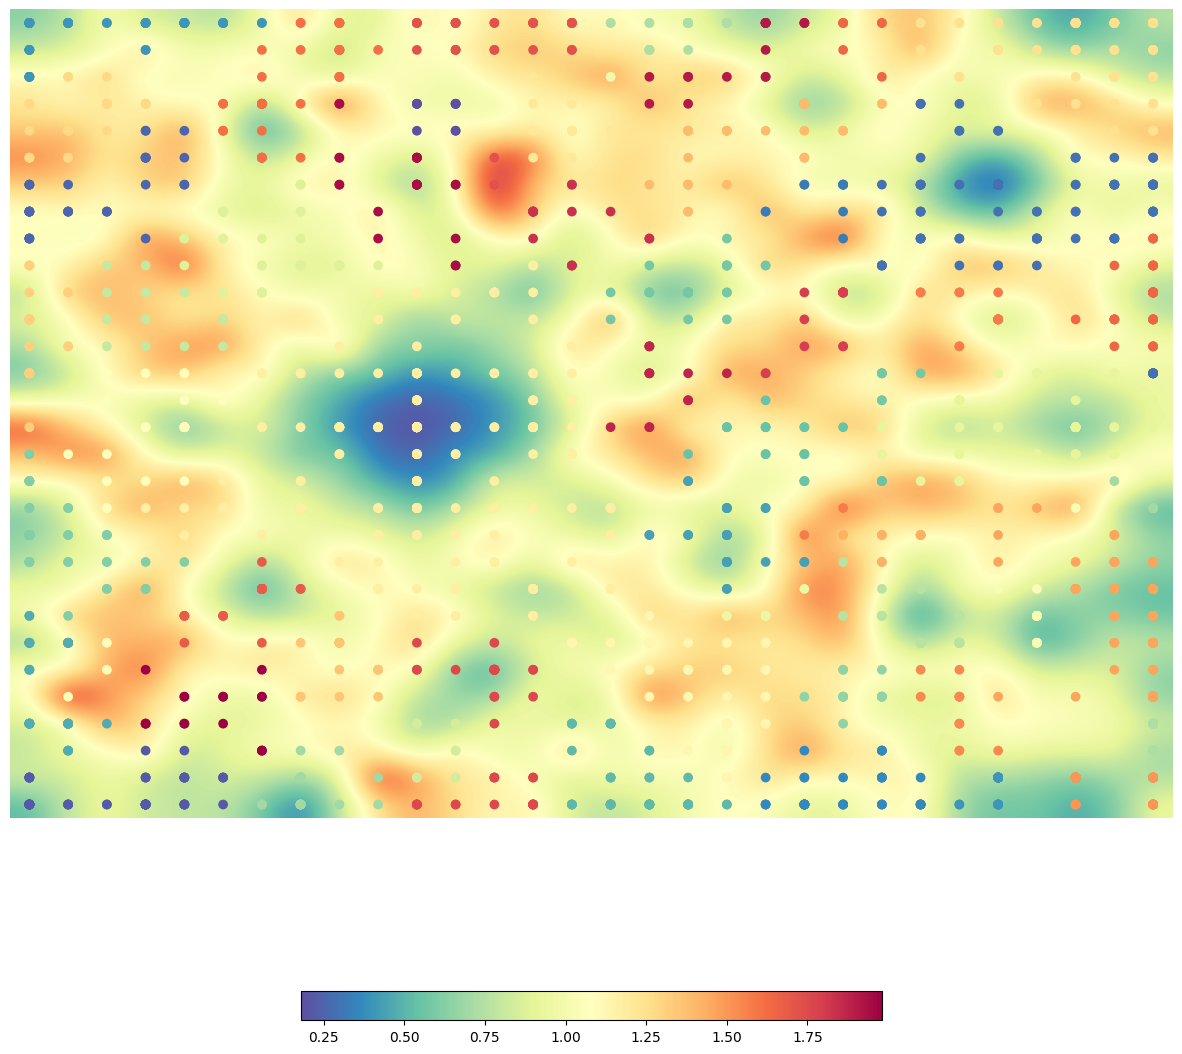

<module 'matplotlib.pyplot' from '/home/natalia/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [370]:
som.view_umatrix(bestmatches=True,figsize=(15,15), colorbar=True)


## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


### k = 20

/home/natalia/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


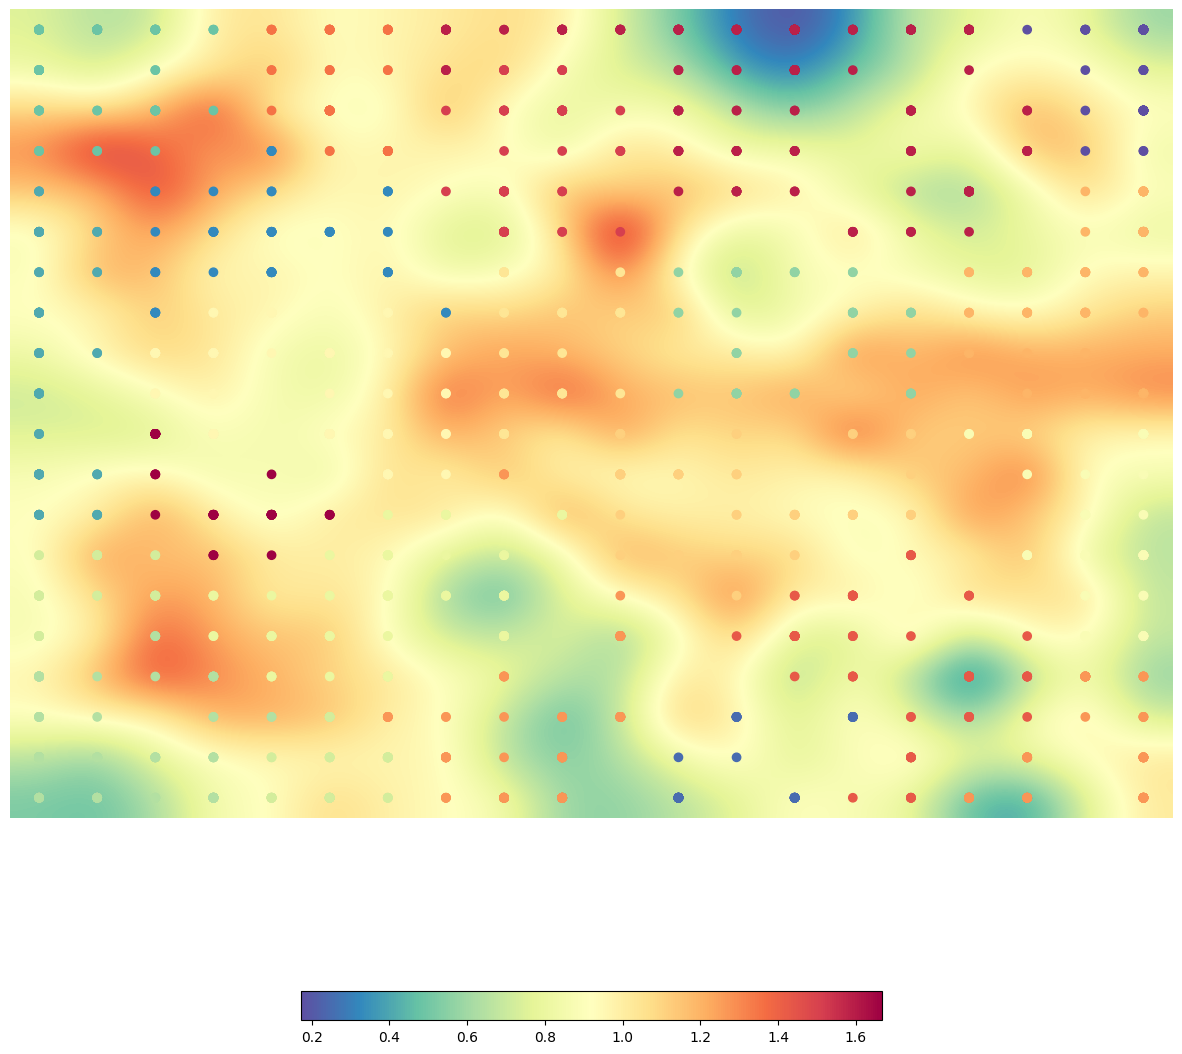

[[ 4  4  4  4 15 15 15 18 18 18 18 18 18 18 18 18 18  0  0  0]
 [ 4  4  4  4 15 15 15 18 17 17 18 18 18 18 18 18 18  0  0  0]
 [ 4  4  4  4 15 15 15 17 17 17 17 18 18 18 18 18 18 18  0  0]
 [ 4  4  4  2  2 15 15 15 17 17 17 18 18 18 18 18 18 18  0  0]
 [ 3  3  2  2  2  2  2 17 17 17 17 18 18 18 18 18 18 18 13 13]
 [ 3  3  2  2  2  2  2 17 17 17 17 18  5 18 18 18 18 13 13 13]
 [ 3  3  2  2  2  2  2  2 11 11 11  5  5  5  5  5 13 13 13 13]
 [ 3  3  2 10 10 10 10  2 11 11 11  5  5  5  5  5 13 13 13 13]
 [ 3  3 10 10 10 10 10 10 11 11 11  5  5  5  5  5 13 13 13 13]
 [ 3  3 10 10 10 10 10 10 11 11 11  5  5  5  5  5  5 13 13 13]
 [ 3 19 19 10 10 10 10 10 11 11 12 12 12 12 12 12  9  9  9  9]
 [ 3  3 19 19 19 19 10 10 14 14 12 12 12 12 12 12  9  9  9  9]
 [ 3  3 19 19 19 19  8  8  8  8 12 12 12 12 12 12 12  9  9  9]
 [ 7  7  7 19 19  8  8  8  8  8 12 12 12 12 16 16 16  9  9  9]
 [ 7  7  7  8  8  8  8  8  8  8 14 12 12 16 16 16 16  9  9  9]
 [ 7  7  6  8  8  8  8  8  8 14 14 14 16 16 16 16 16 16

In [278]:
k = 20
km20 = KMeans(n_clusters=k,random_state=1)
som.cluster(algorithm=km20)
som.view_umatrix(bestmatches=True,figsize=(15,15), colorbar=True)
print(som.clusters)


In [279]:
som.clusters.shape

(20, 20)

In [280]:
cl_id, cl_cnt = np.unique(som.clusters, return_counts = True)
cl_info = dict(zip(cl_id, cl_cnt))
cl_info_sorted = { k: v for k, v in sorted(cl_info.items(), key = lambda item: item[1]) }
print(cl_info_sorted)

{0: 10, 1: 11, 15: 12, 19: 12, 11: 14, 4: 15, 7: 15, 3: 17, 17: 17, 6: 18, 9: 19, 2: 20, 13: 20, 5: 22, 10: 23, 12: 25, 16: 25, 8: 26, 14: 35, 18: 44}


In [281]:
joblib.dump(som,'k20.pkl')

['k20.pkl']

### k=25

/home/natalia/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


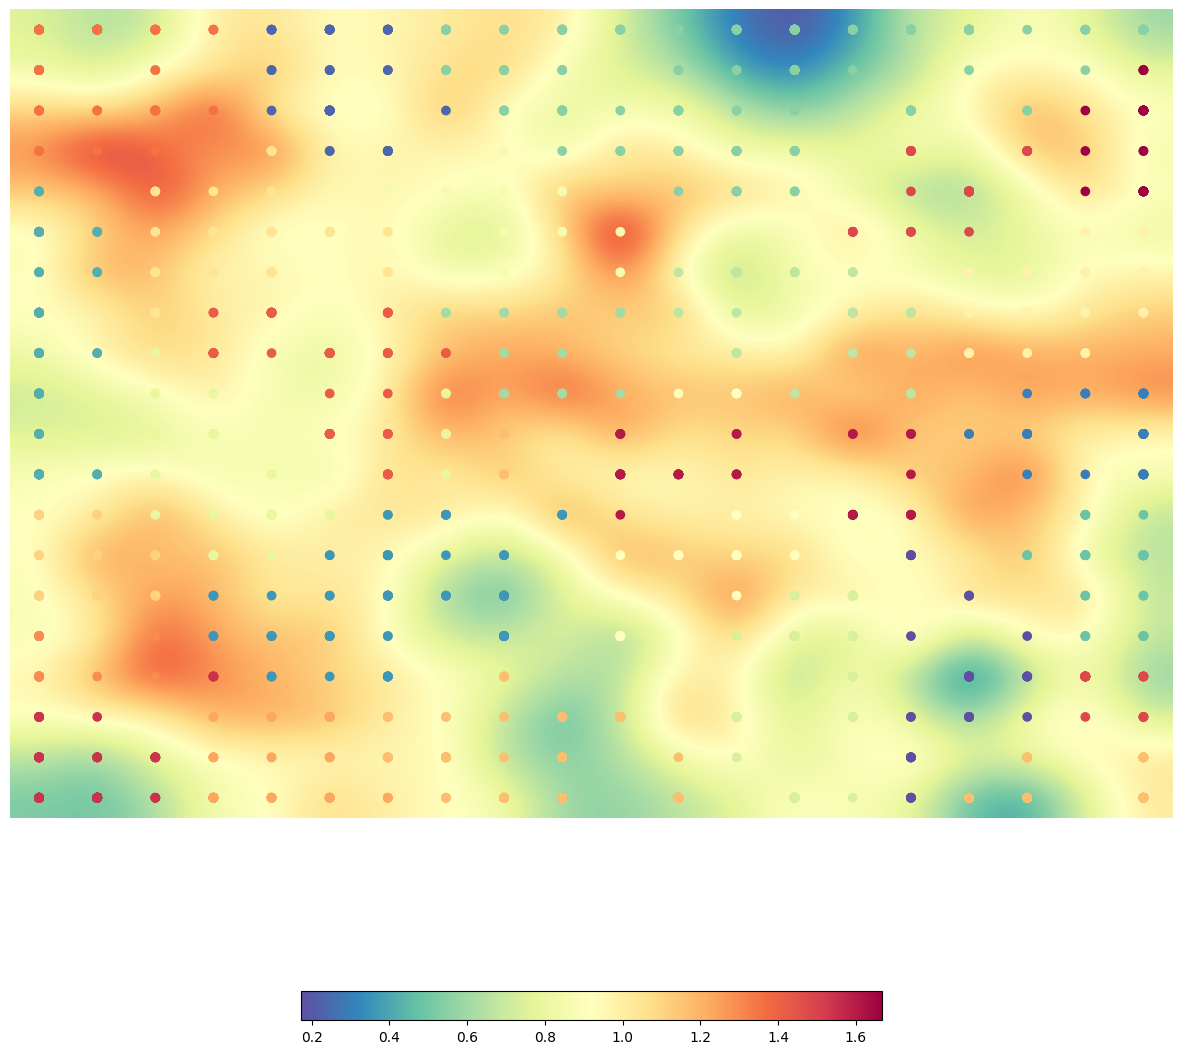

[[19 19 19 19  1  1  1  6  6  6  6  6  6  6  6  6  6  6  6  6]
 [19 19 19 19  1  1  1  6  6  6  6  6  6  6  6  6  6  6  6 24]
 [19 19 19 19  1  1  1  1  6  6  6  6  6  6  6  6  6  6 24 24]
 [19 19 19 14 14  1  1 11 11  6  6  6  6  6  6 21 21 21 24 24]
 [ 4  4 14 14 14 14 11 11 11 11 11  6  6  6 21 21 21 21 24 24]
 [ 4  4 14 14 14 14 14 11 11 11 11  6  8  6 21 21 21 13 13 13]
 [ 4  4 14 14 14 14 14 11 11 11 11  8  8  8  8  8 13 13 13 13]
 [ 4  4 14 20 20 20 20  7  7  7  7  8  8  8  8  8 13 13 13 13]
 [ 4  4 10 20 20 20 20 20  7  7  7  8  8  8  8  8 13 13 13  2]
 [ 4 10 10 10 20 20 20 10  7  7  7 12 12  8  8  8  8  2  2  2]
 [ 4 10 10 10 20 20 20 10 16  7 23 23 23 23 23 23  2  2  2  2]
 [ 4  4 10 10 10 20 20 10 16 16 23 23 23 23 23 23  5  2  2  2]
 [15 15 10 10 10 10  3  3  3  3 23 23 12 12 23 23 23  5  5  5]
 [15 15 15 10 10  3  3  3  3  3 12 12 12 12  0  0  0  5  5  5]
 [15 15 15  3  3  3  3  3  3  3 12 12 12  9  9  0  0  5  5  5]
 [18 18 18  3  3  3  3  3  3 16 12 12  9  9  9  0  0  0

In [282]:
k = 25
km25 = KMeans(n_clusters=k,random_state=1)
som.cluster(algorithm=km25)
som.view_umatrix(bestmatches=True,figsize=(15,15), colorbar=True)
print(som.clusters)

In [283]:
som.clusters.shape

(20, 20)

In [284]:
cl_id, cl_cnt = np.unique(som.clusters, return_counts = True)
cl_info = dict(zip(cl_id, cl_cnt))
cl_info_sorted = { k: v for k, v in sorted(cl_info.items(), key = lambda item: item[1]) }
print(cl_info_sorted)

{18: 6, 24: 7, 15: 8, 17: 10, 22: 10, 2: 11, 7: 11, 1: 12, 5: 12, 4: 14, 12: 14, 13: 14, 21: 14, 11: 15, 19: 15, 0: 16, 9: 17, 14: 17, 20: 17, 23: 17, 10: 19, 8: 20, 3: 26, 16: 32, 6: 46}


In [285]:
joblib.dump(som,'k25.pkl')

['k25.pkl']


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.



## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">




## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.


## Για χάρτη 30x30 και υποσύνολο 2000 ταινιών

In [286]:
n_rows, n_columns = 30, 30
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
subset=final_set[0:2000,:]
%time som.train(subset)

CPU times: user 17min 30s, sys: 12.8 s, total: 17min 43s
Wall time: 1min 24s


/home/natalia/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


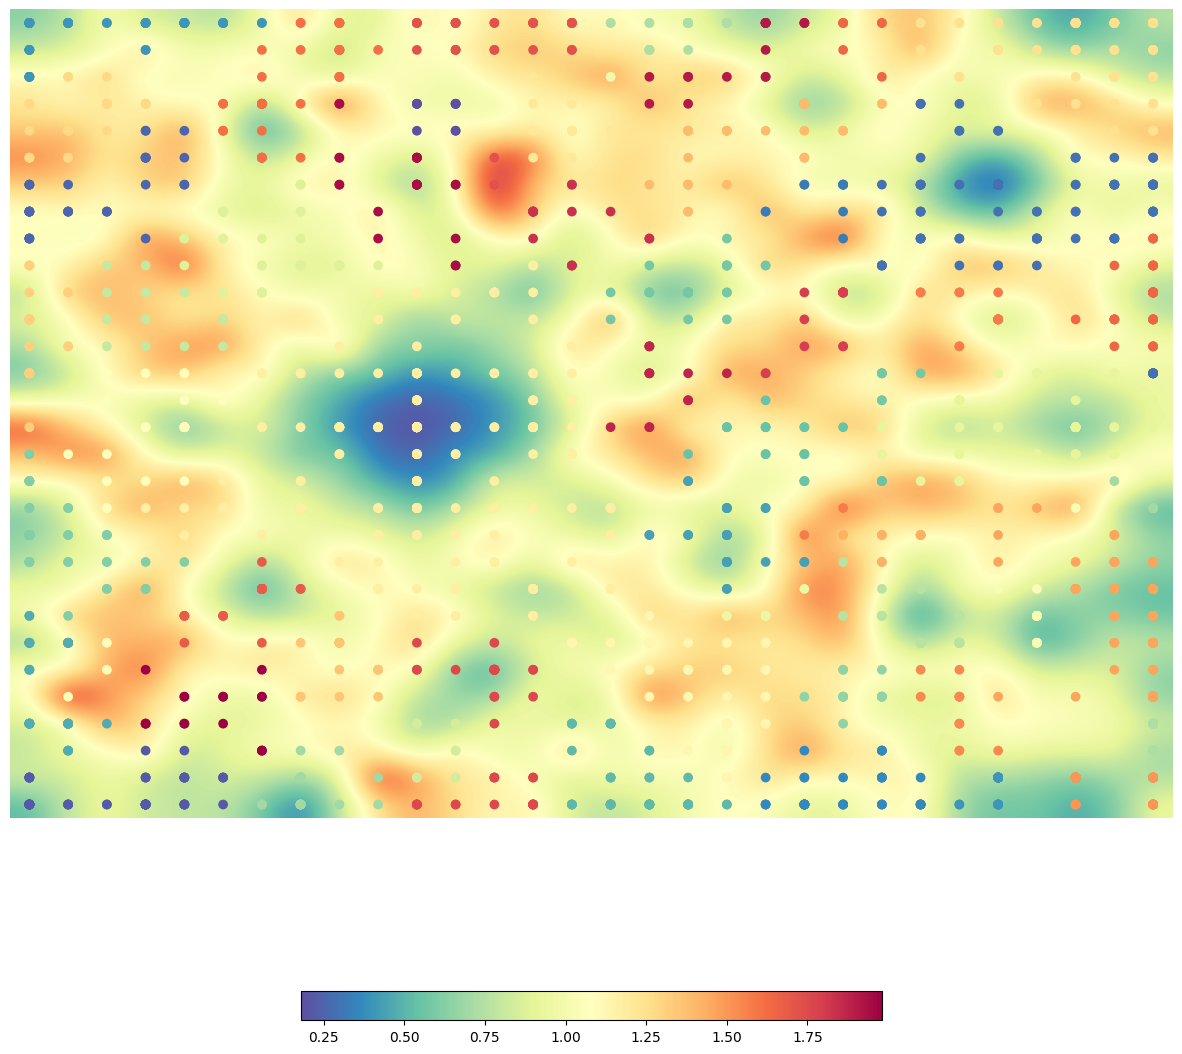

[[ 6  6  6  6  6  6  6 39 39 39 42 42 42 42 42 15 15 15 15 47 47 40 40 29
  29 29 29 29 29 29]
 [ 6  6  6  6  6  6 39 39 39 39 42 42 42 42 42 15 15 15 15 47 47 40 40 29
  29 29 29 29 29 29]
 [ 6 30 30 30 30 39 39 39 39 39  0  0 42 28 22 22 47 47 47 47 33 33 40  3
  29 29 29 29 29 29]
 [30 30 30 30 39 39 39 39 48  0  0  0 28 28 28 22 47 47 33 33 33 33 33  3
   3  3 29 29 29 29]
 [30 30 30  2  2 39 39 39 48 48  0  0 28 28 28 28 33 33 33 33 33 33 33  3
   3  3  3  3 29 29]
 [30 30  2  2  2 39 39 39 48 48 48 48 42 28 28 28 33 33 33 33 33  4  3  3
   3  3  3  3  3  3]
 [ 2  2  2  2  2 19 19 19 48 48 48 48 42 28 45 45 33 33 33  4  4  4  3  3
   3  3  3  3  3  3]
 [ 2  2  2  2 19 19 19 19 19 48 48 48 48 45 45 45 45 33 11  4  4  4  3  3
   3  3  3  3  3  3]
 [ 2  2  2  2 19 19 19 19 19 48 48 48 48 45 45 45 45 11 11 11  4  4  3  3
   3  3  3  3  3 40]
 [31 31 17 17 19 19 19 19 19 19 27 48 27 27 45 45 11 11 11 11 44 44  3  3
   3  3  3  3 40 40]
 [31 31 17 17 17 19 19 19 19 27 27 27 27 27 27 11 

In [287]:
k = 50
km25 = KMeans(n_clusters=k,random_state=1)
som.cluster(algorithm=km25)
som.view_umatrix(bestmatches=True,figsize=(15,15), colorbar=True)
print(som.clusters)

In [288]:
cl_id, cl_cnt = np.unique(som.clusters, return_counts = True)
cl_info = dict(zip(cl_id, cl_cnt))
cl_info_sorted_final = { k: v for k, v in sorted(cl_info.items(), key = lambda item: item[1]) }
print(cl_info_sorted_final)

{22: 3, 25: 5, 21: 6, 0: 7, 4: 9, 18: 9, 34: 9, 36: 9, 37: 9, 8: 10, 13: 10, 47: 10, 15: 12, 16: 12, 28: 12, 32: 12, 38: 12, 45: 12, 17: 13, 23: 13, 30: 13, 31: 13, 42: 13, 5: 14, 44: 14, 10: 15, 41: 15, 46: 15, 49: 15, 1: 16, 9: 16, 14: 16, 40: 17, 2: 18, 6: 18, 7: 18, 12: 20, 48: 20, 24: 22, 39: 22, 33: 23, 43: 23, 19: 24, 26: 25, 29: 26, 11: 27, 35: 28, 20: 32, 3: 47, 27: 121}


In [289]:
joblib.dump(som,'k50_30x30_2000.pkl')

['k50_30x30_2000.pkl']

## Για χάρτη 30x30 και υποσύνολο 5000 ταινιών


In [290]:
n_rows, n_columns = 30, 30
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
subset=final_set[0:5000,:]
%time som.train(subset)

CPU times: user 44min 6s, sys: 17.3 s, total: 44min 23s
Wall time: 3min 27s


/home/natalia/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


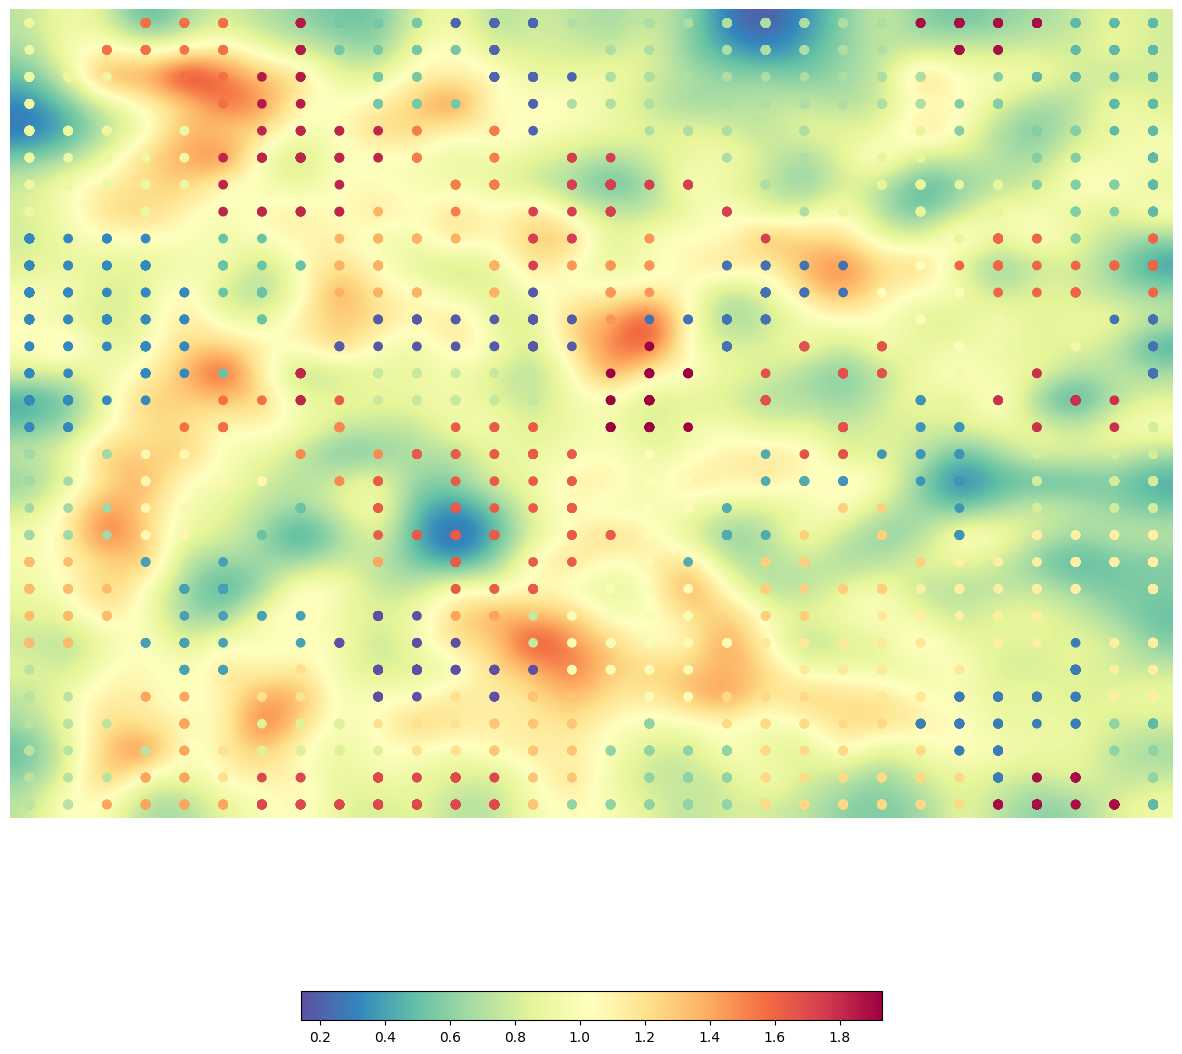

[[21 21 39 39 39 39 47 47 11 11 11  2  2  2 15 15 15 15 15 15 15 15 15 48
  48 48 48  9  9  9]
 [21 21 39 39 39 39 47 47 11 11 11 11  2  2 15 15 15 15 15 15 15 15 15 15
  48 48 48  9  9  9]
 [21 21 21 39 39 39 47 47 11 11 11  2  2  2  2 15 15 15 15 15 15 15 15 15
  48 12  9  9  9  9]
 [21 21 21 21 47 39 47 47 11 11 11 11  2  2 15 15 15 15 15 15 15 15 15 15
  12 12 12 12  9  9]
 [21 21 21 21 21 46 46 46 46 46 38 38 38  2 44 15 15 15 15 15 15 15 15 20
  12 12 12 12  9  9]
 [21 21 21 21 21 46 46 46 46 46 38 38 38 44 44 44 44 44 15 15 15 15 20 20
  20 12 12 12  9  9]
 [21 21 21 21 21 46 46 46 46 46 38 38 38 44 44 44 44 44 44 15 15 15 20 20
  20 20 12 12 12  9]
 [21 21 21 21 21 46 46 46 46 34 34 38 38 44 44 44 44 44 44 15 15 20 20 20
  20 20 12 12 12  9]
 [ 5  5  5  5 10 10 10 34 34 34 34 34 34 44 44 36 36 36 44 44 44 20 20 20
  20 40 40 12 40 40]
 [ 5  5  5  5  5 10 10 10 34 34 34 34 34 44 36 36 36 36  3  3  3  3 24 24
  40 40 40 40 40 40]
 [ 5  5  5  5  5 10 10 10 34 34 34 34 34  1 36 36 

In [291]:
k = 50
km25 = KMeans(n_clusters=k,random_state=1)
som.cluster(algorithm=km25)
som.view_umatrix(bestmatches=True,figsize=(15,15), colorbar=True)
print(som.clusters)

In [292]:
cl_id, cl_cnt = np.unique(som.clusters, return_counts = True)
cl_info = dict(zip(cl_id, cl_cnt))
cl_info_sorted = { k: v for k, v in sorted(cl_info.items(), key = lambda item: item[1]) }
print(cl_info_sorted)

{22: 7, 19: 9, 37: 9, 47: 9, 25: 10, 14: 11, 24: 11, 32: 11, 36: 11, 38: 11, 45: 11, 49: 11, 2: 12, 29: 12, 8: 13, 18: 13, 33: 13, 43: 13, 11: 14, 17: 14, 1: 15, 48: 15, 16: 16, 26: 16, 28: 16, 40: 16, 0: 17, 4: 17, 20: 17, 34: 18, 35: 18, 39: 18, 12: 19, 31: 19, 6: 20, 9: 20, 10: 20, 13: 20, 42: 20, 3: 22, 7: 22, 23: 23, 46: 23, 44: 24, 30: 25, 21: 31, 27: 34, 5: 37, 41: 42, 15: 55}


In [293]:
joblib.dump(som,'k50_30x30_5000.pkl')

['k50_30x30_5000.pkl']

## Για χάρτη 20x20 και υποσύνολο 2000 ταινιών

In [294]:
n_rows, n_columns = 20, 20
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
subset=final_set[0:2000,:]
%time som.train(subset)

CPU times: user 6min 43s, sys: 2.54 s, total: 6min 46s
Wall time: 33.1 s


/home/natalia/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


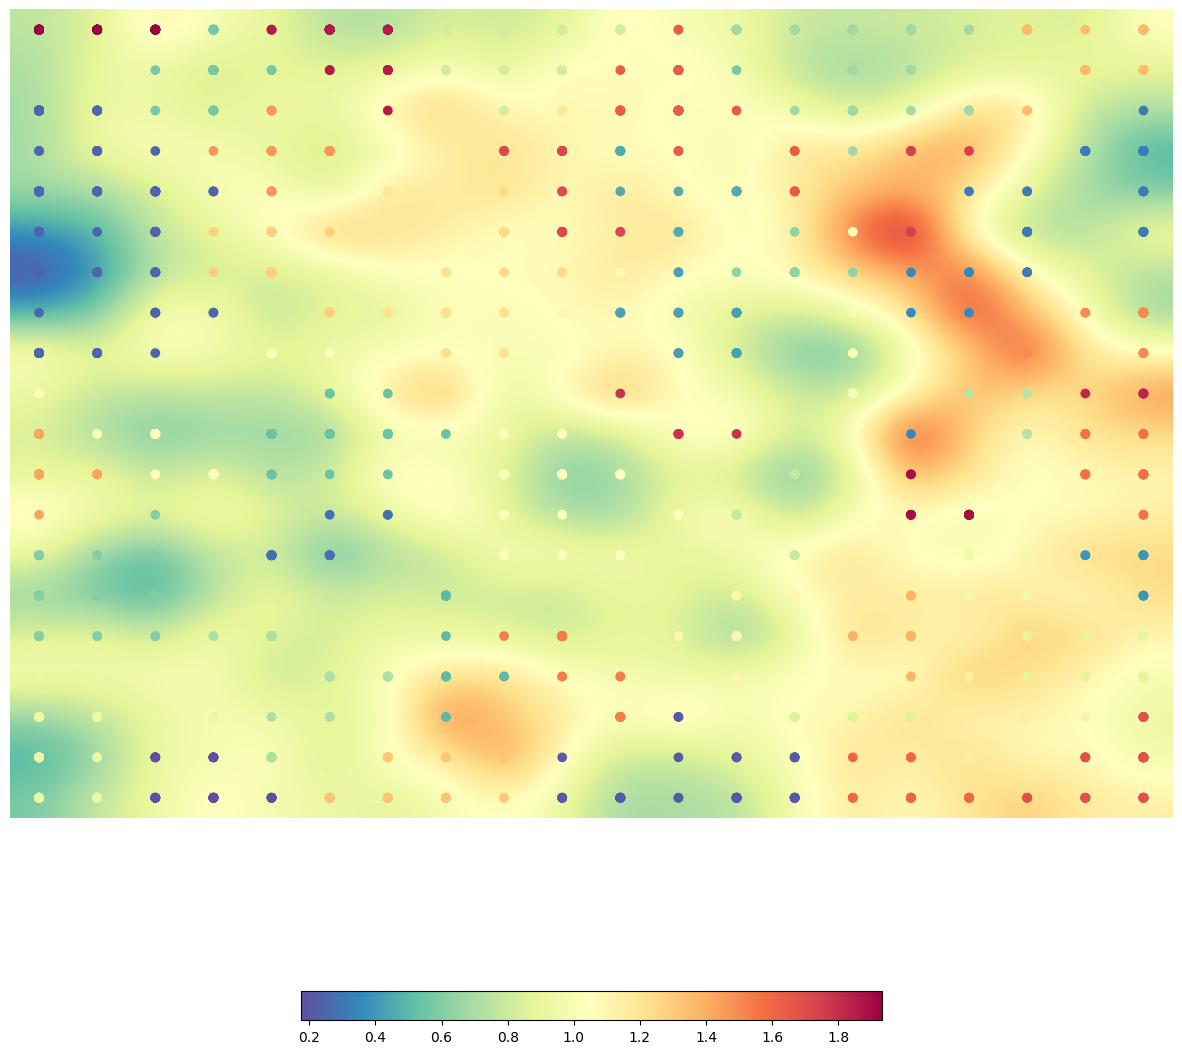

[[49 49 49 11 47 47 47 18 18 18 18 41 14 14 14 14 14 33 33 33]
 [49 49 11 11 11 47 47 18 18 18 41 41 11 14 14 14 14 33 33 33]
 [ 2  2 11 11 36 36 47 28 18 28 41 41 41 14 14 14 14 33 33  4]
 [ 2  2  2 36 36 36 36 28 43 43  8 41 41 41 14 44 44  4  4  4]
 [ 2  2  2  2 36 36 28 28 30 43  8  8  8 41 41 44  4  4  4  4]
 [ 2  2  2 31 31 31 28 30 30 43 43  8  8 13 23 44  4  4  4  4]
 [ 2  2  2 31 31 31 29 29 30 30 23  7 13 13 13  5  5  4 37 37]
 [ 2  2  2  2 31 31 29 29 29 23  7  7  7 13 23  5  5 37 37 37]
 [ 2  2  2 24 24 24 29 29 29 24  7  7  7 23 23 23  5 37 37 37]
 [25 25 25 25 24 10 10 29 24 24 45 45  7 23 23 23 16 16 46 46]
 [35 25 25 25 10 10 10 10 24 24 45 45 45 17 17  5 16 16 39 39]
 [35 35 25 25 10 10 10 24 24 24 24 24 17 17 17 48 48 16 39 39]
 [35 35 12 25 10  3  3 24 24 24 24 24 17 17 48 48 48 48 39 39]
 [12 12 12 12  3  3  3  9 24 24 24 24 17 17 17 48 22 22  6  6]
 [12 12 12 12 15  3  9  9  9 24 24 26 26 26 26 34 22 22  6  6]
 [12 12 12 15 15 15  9  9 38 38 38 26 26 26 34 34 34 20

In [295]:
k = 50
km25 = KMeans(n_clusters=k,random_state=1)
som.cluster(algorithm=km25)
som.view_umatrix(bestmatches=True,figsize=(15,15), colorbar=True)
print(som.clusters)

In [296]:
cl_id, cl_cnt = np.unique(som.clusters, return_counts = True)
cl_info = dict(zip(cl_id, cl_cnt))
cl_info_sorted = { k: v for k, v in sorted(cl_info.items(), key = lambda item: item[1]) }
print(cl_info_sorted)

{46: 2, 6: 4, 22: 4, 44: 4, 0: 5, 13: 5, 16: 5, 30: 5, 34: 5, 35: 5, 40: 5, 43: 5, 45: 5, 49: 5, 3: 6, 5: 6, 8: 6, 19: 6, 20: 6, 27: 6, 28: 6, 39: 6, 42: 6, 47: 6, 11: 7, 48: 7, 7: 8, 18: 8, 26: 8, 31: 8, 32: 8, 33: 8, 36: 8, 37: 8, 38: 8, 29: 9, 9: 10, 10: 10, 17: 10, 23: 10, 25: 10, 1: 11, 21: 11, 41: 11, 12: 12, 15: 12, 4: 13, 14: 14, 2: 22, 24: 25}


In [297]:
joblib.dump(som,'k50_20x20_2000.pkl')

['k50_20x20_2000.pkl']

In [342]:
som=joblib.load('k50_30x30_2000.pkl')

Μέτα από αρκετές δοκιμές με διαφορετικά μεγέθη χάρτη και υποσύνολα ταινιών, έχουμε παρατηρήσει ότι οι παραμέτροι που επηρεάζουν την ποιότητα του clustering είναι οι εξής:
* Το μέγεθος του χάρτη
* το μηκος του συνόλου των ταινιών 
* και σε μικρότερο βαθμό το k του k-Means

Επιλέγουμε τον χάρτη 30x30 για το υποσύνολο των 2000 ταινιών.

In [343]:
main_categ =[]
min_categ=[]

def print_categories_stats(list_ids):
    global main_categ
    global min_categ
    total_categ=[]
    for id in list_ids:
        total_categ.extend([x.replace("\"","").strip() for x in categories[id][0].split(",")])
    
    

    cl_id, cl_cnt = np.unique(total_categ, return_counts = True)
    cl_info = dict(zip(cl_id, cl_cnt))
    cl_info_sorted = { k: v for k, v in sorted(cl_info.items(), key = lambda item: item[1]) }
    #take only the last 3
    main_categ=list(cl_info_sorted)[-3:]
    min_categ=list(cl_info_sorted)[:3]
    print(cl_info_sorted)

    
        
    

In [344]:
print_categories_stats(list(range(0,2000)))

{'Albino bias': 1, 'Archives and records': 1, 'Costume Horror': 1, 'Early Black Cinema': 1, 'Educational': 1, 'Environmental Science': 1, 'Exploitation': 1, 'Extreme Sports': 1, 'Fantasy Drama': 1, 'Future noir': 1, 'Gender Issues': 1, 'Giallo': 1, 'Glamorized Spy Film': 1, 'Goat gland': 1, 'Health & Fitness': 1, 'Illnesses & Disabilities': 1, 'Indian Western': 1, 'Inspirational Drama': 1, 'Instrumental Music': 1, 'Interpersonal Relationships': 1, 'Kitchen sink realism': 1, 'Mumblecore': 1, 'Mythological Fantasy': 1, 'Neo-noir': 1, 'News': 1, 'Parkour in popular culture': 1, 'Plague': 1, 'Point of view shot': 1, 'Political satire': 1, 'Prison film': 1, 'Psychological horror': 1, 'Race movie': 1, 'Reboot': 1, 'Road-Horror': 1, 'Roadshow/Carny': 1, 'Spaghetti Western': 1, 'Splatter film': 1, 'Stand-up comedy': 1, 'Steampunk': 1, 'Stoner film': 1, 'Supermarionation': 1, 'Sword and Sandal': 1, 'Sword and sorcery films': 1, 'Therimin music': 1, 'Tollywood': 1, 'Travel': 1, 'Airplanes and ai

In [345]:
def print_cluster_neurons_movies_report(id_cluster):
    x,y=np.where(id_cluster==som.clusters)
    a_list = []
    bmus =  np.column_stack((y,x))
    
    for b in bmus:
        if(b in ubmus):
            a_list.append(b)
    
    return a_list



In [346]:
print_cluster_neurons_movies_report(10)

[array([19, 14]),
 array([20, 14]),
 array([18, 15]),
 array([19, 15]),
 array([20, 15]),
 array([21, 15]),
 array([17, 16]),
 array([18, 16]),
 array([19, 16]),
 array([20, 16]),
 array([21, 16]),
 array([19, 17]),
 array([20, 17]),
 array([21, 17]),
 array([22, 17])]

In [347]:
np.where(10==som.clusters)

(array([14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17]),
 array([19, 20, 18, 19, 20, 21, 17, 18, 19, 20, 21, 19, 20, 21, 22]))

In [348]:
def neuron_movies_report(neurns):
    mv_res = []
    for n in neurns:
        for i,mvie in enumerate(som.bmus):
            if(np.equal(n,mvie).all()):
                mv_res.append(i)
    print_categories_stats(mv_res)
   

In [349]:
neuron_movies_report(print_cluster_neurons_movies_report(19))

{'Bollywood': 1, 'Comedy Western': 1, 'Costume drama': 1, 'Epic': 1, 'History': 1, 'Indian Western': 1, 'Political drama': 1, 'Romance Film': 1, 'Television movie': 1, 'Thriller': 1, 'War film': 1, 'Historical fiction': 2, 'Revisionist Western': 2, 'Black-and-white': 3, 'Film adaptation': 3, 'Adventure': 4, 'World cinema': 5, 'Drama': 8, 'Action': 9, 'Western': 26, 'Action/Adventure': 27}




## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook. Η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν είναι χάρτης SOM καιδεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας.

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.


Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.


1. Με χρήση της συνάρτησης print_categories_stats βρίσκουμε την συχνότητα όλων των κατηγοριών για το υποσύνολο που εξετάζουμε. Για κάθε cluster τυπώνουμε τις κατηγορίες των ταινιών που περιλαμβάνει και παρατηρούμε ότι οι κατηγορίες που εμφανίζονται πιο συχνά 

In [350]:
print("Cluster: "+str(26))
neuron_movies_report(print_cluster_neurons_movies_report(26))

Cluster: 26
{'Action': 1, 'Action Thrillers': 1, 'Action/Adventure': 1, 'Black comedy': 1, 'Comedy film': 1, 'Comedy-drama': 1, 'Courtroom Drama': 1, 'Crime': 1, 'Doomsday film': 1, 'Indie': 1, 'Melodrama': 1, 'Prison': 1, 'Science Fiction': 1, 'Social problem film': 1, 'Television movie': 1, 'Comedy': 2, 'Detective': 2, 'Detective fiction': 2, 'Disaster': 2, 'Period piece': 2, 'Political drama': 2, 'Slasher': 2, 'Supernatural': 2, 'Political thriller': 3, 'Romance Film': 3, 'War film': 3, 'World cinema': 3, 'Film noir': 5, 'Spy': 5, 'Film adaptation': 6, 'Black-and-white': 9, 'Crime Thriller': 10, 'Horror': 10, 'Suspense': 11, 'Psychological thriller': 18, 'Mystery': 25, 'Drama': 46, 'Thriller': 46}


In [351]:
sum_categories = {}

for i in range(50):
    
    print("Cluster: "+str(i))
    neuron_movies_report(print_cluster_neurons_movies_report(i))
    for m in main_categ:
        if m in sum_categories.keys():
            sum_categories[m]+=cl_info_sorted_final[i]
        else:
            sum_categories[m]=cl_info_sorted_final[i]
    for m in min_categ:
        if m in sum_categories.keys():
            sum_categories[m]+=cl_info_sorted_final[i]
        else:
            sum_categories[m]=cl_info_sorted_final[i]


Cluster: 0
{"Children's/Family": 1, 'Chinese Movies': 1, 'Comedy film': 1, 'Fantasy Adventure': 1, 'Martial Arts Film': 1, 'Spy': 1, 'Swashbuckler films': 1, 'Science Fiction': 2, 'Jungle Film': 3, 'Black-and-white': 4, 'Adventure': 11}
Cluster: 1
{'Addiction Drama': 1, 'British New Wave': 1, 'Christian film': 1, 'Comedy of manners': 1, 'Costume drama': 1, 'Cult': 1, 'Docudrama': 1, 'Domestic Comedy': 1, 'Erotic Drama': 1, 'Family Film': 1, 'Inspirational Drama': 1, 'Kitchen sink realism': 1, 'Martial Arts Film': 1, 'Musical': 1, 'Parody': 1, 'Political cinema': 1, 'Punk rock': 1, 'Romantic fantasy': 1, 'Satire': 1, 'Sex comedy': 1, 'Slice of life story': 1, 'Sports': 1, 'Spy': 1, 'Suspense': 1, 'Tamil cinema': 1, 'Teen': 1, 'War film': 1, 'Western': 1, 'Action': 2, 'Biographical film': 2, 'Biopic [feature]': 2, 'Black comedy': 2, 'Courtroom Drama': 2, 'Crime Fiction': 2, 'Epic': 2, 'Japanese Movies': 2, 'Mystery': 2, 'New Hollywood': 2, 'Political drama': 2, 'Supernatural': 2, 'Traged

In [352]:
#'Action': 271, 'Romance Film': 287, 'Thriller': 333, 'Comedy': 495, 'Drama': 948
print("For category Action ", sum_categories['Action'])
print("For category Romance Film ", sum_categories['Romance Film'])
print("For category Thriller ", sum_categories['Thriller'])
print("For category Comedy ", sum_categories['Comedy'])
print("For category Drama ", sum_categories['Drama'])


For category Action  254
For category Romance Film  165
For category Thriller  105
For category Comedy  272
For category Drama  449


In [353]:
print("For category Albino bias ", sum_categories['Albino bias'])
# print("For category Educational ", sum_categories['Educational'])
# print("For category Environmental Science ", sum_categories['Environmental Science'])


For category Albino bias  26


Προφανώς στις κατηγορίες με χαμηλή συχνότητα εμφάνησης η συμμετοχή τους σε κάποιος νευρώνες είναι αρκετά περίπλοκη ως προς τον υπολογισμό καθώς δεν υπάρχει παρουσία τους ούτε και στο ελάχιστο σε αρκετούς κόμβους.

2. Για πάραδειγμα του φαινομένου που παρουσιάζεται στην εκφώνηση, παίρνουμε τα clusters 14 και 15
 

In [354]:
print("Cluster: "+str(14))
neuron_movies_report(print_cluster_neurons_movies_report(14))
print("Cluster: "+str(15))
neuron_movies_report(print_cluster_neurons_movies_report(15))

Cluster: 14
{'Action': 1, 'Bollywood': 1, 'Buddy film': 1, 'Chinese Movies': 1, 'Costume drama': 1, 'Dance': 1, 'Hip hop movies': 1, 'Marriage Drama': 1, 'Mystery': 1, 'Period piece': 1, 'Road movie': 1, 'Short Film': 1, 'Thriller': 1, 'War film': 1, 'Western': 1, 'Coming of age': 2, 'Family Film': 2, 'Fantasy': 2, 'Japanese Movies': 2, 'Melodrama': 2, 'Romantic comedy': 2, 'Indie': 3, 'Adventure': 4, 'Musical': 7, 'Comedy film': 8, 'Drama': 46, 'Romance Film': 67}
Cluster: 15
{'Adventure': 1, 'Animal Picture': 1, 'Anime': 1, 'Documentary': 1, 'Fantasy': 1, 'Japanese Movies': 1, "Children's": 2, "Children's/Family": 2, 'Musical': 3, 'Comedy film': 9, 'Short Film': 12, 'Animation': 20, 'Family Film': 20}


Το cluster 17 απεικονίζεται στην αριστερή πλευρά του πίνακα ενώ το cluster 12 απεικονίζεται στην δεξιά. Όσον αφορά τις κυρίαρχες κατηγορίες των δύο αυτών clusters παρατηρούμε ότι και εννοιολογικά είναι απομακρυσμένες (Thriller και Comedy). Αντίστοιχα και για τα clusters 39 και 5.

In [355]:
print("Cluster: "+str(39))
neuron_movies_report(print_cluster_neurons_movies_report(39))
print("Cluster: "+str(5))
neuron_movies_report(print_cluster_neurons_movies_report(5))

Cluster: 39
{'Alien Film': 1, 'Apocalyptic and post-apocalyptic fiction': 1, 'Black-and-white': 1, "Children's/Family": 1, 'Creature Film': 1, 'Crime Thriller': 1, 'Cult': 1, 'Doomsday film': 1, 'Fantasy': 1, 'Japanese Movies': 1, 'Martial Arts Film': 1, 'Music': 1, 'Period piece': 1, 'Remake': 1, 'Road movie': 1, 'Sports': 1, 'Spy': 1, 'Swashbuckler films': 1, 'Sword and Sandal': 1, 'Tamil cinema': 1, 'World cinema': 1, 'Adventure Comedy': 2, 'Chinese Movies': 2, 'Comedy film': 2, 'Musical': 2, 'Short Film': 2, 'Superhero': 2, 'Zombie Film': 2, 'Family Film': 3, 'Horror': 3, 'Indie': 3, 'Superhero movie': 3, 'Comedy': 4, 'Romance Film': 4, 'Crime Fiction': 5, 'Action/Adventure': 6, 'Science Fiction': 7, 'Adventure': 18, 'Action': 45}
Cluster: 5
{'Courtroom Drama': 1, 'Detective': 1, 'Detective fiction': 1, 'Drama': 1, 'Fantasy': 1, 'Horror': 1, 'Indie': 1, 'Neo-noir': 1, 'Supernatural': 1, 'Surrealism': 1, 'Suspense': 1, 'Television movie': 1, 'Crime Fiction': 2, 'Mystery': 3, 'Crime 

3. Όμοιως, παραθέτουμε παραδείγματα απο clusters που εμφανίζονται κοντά τοπολογικά στον χάρτη και βλέπουμε ότι και οι κυρίαρχες κατηγοριες είναι ίδιες.

In [356]:
print("Cluster: "+str(43))
neuron_movies_report(print_cluster_neurons_movies_report(43))
print("Cluster: "+str(9))
neuron_movies_report(print_cluster_neurons_movies_report(9))

Cluster: 43
{'Biography': 1, 'Black comedy': 1, 'Comedy': 1, 'Comedy film': 1, 'Comedy-drama': 1, 'Crime Comedy': 1, 'Ensemble Film': 1, 'Erotic thriller': 1, 'Family Drama': 1, 'Musical': 1, 'Prison': 1, 'Romantic comedy': 1, 'Short Film': 1, 'Silent film': 1, 'Slice of life story': 1, 'Sports': 1, 'Television movie': 1, 'World cinema': 1, 'Action/Adventure': 2, 'Biographical film': 2, 'Biopic [feature]': 2, 'Coming of age': 2, 'Film noir': 2, 'Juvenile Delinquency Film': 2, 'Mystery': 2, 'Period piece': 2, 'Action': 3, 'Film adaptation': 3, 'Melodrama': 3, 'Teen': 3, 'Gangster Film': 4, 'Indie': 4, 'Black-and-white': 5, 'Crime Thriller': 5, 'Romance Film': 5, 'Thriller': 9, 'Crime Drama': 11, 'Crime Fiction': 42, 'Drama': 42}
Cluster: 9
{'Adventure': 1, 'Biopic [feature]': 1, 'Buddy film': 1, 'Caper story': 1, 'Comedy': 1, 'Comedy Thriller': 1, 'Comedy film': 1, 'Coming of age': 1, 'Costume drama': 1, 'Docudrama': 1, 'Fantasy': 1, 'Horror': 1, 'Indie': 1, 'Melodrama': 1, 'Period piec

In [357]:
print("Cluster: "+str(27))
neuron_movies_report(print_cluster_neurons_movies_report(27))
print("Cluster: "+str(11))
neuron_movies_report(print_cluster_neurons_movies_report(11))

Cluster: 27
{'Addiction Drama': 1, 'Americana': 1, 'Animation': 1, 'Auto racing': 1, 'Black comedy': 1, 'Bollywood': 1, 'British New Wave': 1, "Children's": 1, 'Courtroom Drama': 1, 'Crime Drama': 1, 'Czechoslovak New Wave': 1, 'Docudrama': 1, 'Epic': 1, 'Erotic Drama': 1, 'Family-Oriented Adventure': 1, 'Feminist Film': 1, 'Filipino Movies': 1, 'Juvenile Delinquency Film': 1, 'Marriage Drama': 1, 'Musical Drama': 1, 'Prison': 1, 'Psychological horror': 1, 'Psychological thriller': 1, 'Satire': 1, 'Slice of life story': 1, 'Surrealism': 1, 'Western': 1, 'Art film': 2, "Children's/Family": 2, 'Christian film': 2, 'Coming of age': 2, 'Costume drama': 2, 'Hagiography': 2, 'Hip hop movies': 2, 'Historical Epic': 2, 'Historical drama': 2, 'History': 2, 'Horror': 2, 'Medical fiction': 2, 'Music': 2, 'Road movie': 2, 'Silent film': 2, 'Social problem film': 2, 'Sports': 2, 'Teen': 2, 'Chinese Movies': 3, 'Fantasy': 3, 'Historical fiction': 3, 'Melodrama': 3, 'Romantic drama': 3, 'Biopic [feat

In [358]:
print("Cluster: "+str(17))
neuron_movies_report(print_cluster_neurons_movies_report(17))
print("Cluster: "+str(27))
neuron_movies_report(print_cluster_neurons_movies_report(27))

Cluster: 17
{'Biography': 1, 'Fantasy Adventure': 1, 'Indie': 1, 'Political drama': 1, 'Propaganda film': 1, 'Romance Film': 1, 'Silent film': 1, 'Television movie': 1, 'Thriller': 1, 'Docudrama': 2, 'Historical fiction': 2, 'Jungle Film': 2, 'Period piece': 2, 'Swashbuckler films': 2, 'Costume Adventure': 3, 'Epic': 3, 'Film adaptation': 3, 'Black-and-white': 4, 'Costume drama': 4, 'War film': 6, 'Action': 11, 'Action/Adventure': 12, 'Adventure': 15, 'Drama': 16}
Cluster: 27
{'Addiction Drama': 1, 'Americana': 1, 'Animation': 1, 'Auto racing': 1, 'Black comedy': 1, 'Bollywood': 1, 'British New Wave': 1, "Children's": 1, 'Courtroom Drama': 1, 'Crime Drama': 1, 'Czechoslovak New Wave': 1, 'Docudrama': 1, 'Epic': 1, 'Erotic Drama': 1, 'Family-Oriented Adventure': 1, 'Feminist Film': 1, 'Filipino Movies': 1, 'Juvenile Delinquency Film': 1, 'Marriage Drama': 1, 'Musical Drama': 1, 'Prison': 1, 'Psychological horror': 1, 'Psychological thriller': 1, 'Satire': 1, 'Slice of life story': 1, 'S

### Clusters κοντινά χωρίς εννοιολογική συνάφεια

In [359]:
print("Cluster: "+str(48))
neuron_movies_report(print_cluster_neurons_movies_report(48))
print("Cluster: "+str(45))
neuron_movies_report(print_cluster_neurons_movies_report(45))

Cluster: 48
{'Action/Adventure': 1, 'Creature Film': 1, 'Cult': 1, 'Fantasy': 1, 'Future noir': 1, 'Hybrid Western': 1, 'Monster': 1, 'Mystery': 1, 'Parody': 1, 'Prison': 1, 'Sports': 1, 'Superhero movie': 1, 'Thriller': 1, 'Time travel': 1, 'Western': 1, 'Animation': 3, 'Anime': 3, 'Disaster': 3, 'Drama': 3, 'Television movie': 3, 'World cinema': 3, 'Action': 4, 'Japanese Movies': 4, 'Science Fiction': 24}
Cluster: 45
{'Animation': 1, 'Black-and-white': 1, 'Bollywood': 1, 'Childhood Drama': 1, "Children's/Family": 1, 'Comedy-drama': 1, 'Fantasy Comedy': 1, 'Heavenly Comedy': 1, 'Indie': 1, 'Sports': 1, 'Television movie': 1, 'World cinema': 1, 'Family-Oriented Adventure': 2, 'Fantasy': 2, 'Musical': 2, 'Period piece': 2, 'Adventure': 3, 'Comedy': 3, 'Coming of age': 4, 'Family Drama': 9, 'Drama': 16, 'Family Film': 16}


### Clusters χωρις εννοιολογική συνάφεια

In [360]:
print("Cluster: "+str(42))
neuron_movies_report(print_cluster_neurons_movies_report(42))

Cluster: 42
{'Alien Film': 1, 'Chinese Movies': 1, 'Christian film': 1, 'Christmas movie': 1, 'Comedy': 1, 'Cult': 1, 'Doomsday film': 1, 'Epic': 1, 'Filipino Movies': 1, 'Monster': 1, 'Musical': 1, 'Mythological Fantasy': 1, 'Period piece': 1, 'Sci-Fi Adventure': 1, 'Sword and sorcery films': 1, 'Time travel': 1, 'Wuxia': 1, 'Animated Musical': 2, 'Anime': 2, 'Costume drama': 2, 'Family-Oriented Adventure': 2, 'Indie': 2, 'Martial Arts Film': 2, 'Mystery': 2, 'Short Film': 2, 'Stop motion': 2, 'Horror': 3, 'Japanese Movies': 3, 'Romance Film': 3, 'Action/Adventure': 4, "Children's": 4, 'Computer Animation': 4, 'Drama': 5, 'Thriller': 5, 'Action': 6, 'Fantasy Adventure': 10, 'Science Fiction': 10, "Children's Fantasy": 11, "Children's/Family": 12, 'Animation': 15, 'Family Film': 15, 'Adventure': 28, 'Fantasy': 31}


Εδώ παρατηρούμε ότι στο ίδιο cluster έχουμε ταινία με κατηγορία Children's/Family και ταινία με κατηγορία Thriller. Αυτό συμβαίνει επειδή οι ταινίες παρουσιάζουν κάποιες κύριες κατηγορίες κοινές. 

In [361]:
print("Cluster: "+str(32))
neuron_movies_report(print_cluster_neurons_movies_report(32))

Cluster: 32
{'Action': 1, 'Comedy': 1, 'Goat gland': 1, 'Melodrama': 1, 'Pre-Code': 1, 'Short Film': 1, 'War film': 1, 'Romance Film': 3, 'Crime Fiction': 5, 'Drama': 12, 'Indie': 12, 'Black-and-white': 16, 'Silent film': 16}


Τέλος, εδώ παρατηρούμε ότι στο ίδιο cluster εχουμε ταινίες με κατηγορία War film και Romance Film. Αυτό συμβαίνει γιατί κάποιες κατηγορίες που δεν αντιπρωσοπεύουν μεγάλο μέρος του συνόλου εισόδου δεν αντιπροσωπεύονται ικανοποιητικά από κανέναν cluster. Ετσι η ταξινόμηση τους εξαρτάται από την τυχαιότητα των αρχικών συνθηκών και από παραμέτρους υπολογισμού του αλγορίθμου της απόστασης. 

49,32,41,8,1,26,9,5,13

In [376]:
print("Cluster: "+str(0))
neuron_movies_report(print_cluster_neurons_movies_report(0))
print("Cluster: "+str(48))
neuron_movies_report(print_cluster_neurons_movies_report(48))
print("Cluster: "+str(28))
neuron_movies_report(print_cluster_neurons_movies_report(28))
print("Cluster: "+str(42))
neuron_movies_report(print_cluster_neurons_movies_report(42))


Cluster: 0
{"Children's/Family": 1, 'Chinese Movies': 1, 'Comedy film': 1, 'Fantasy Adventure': 1, 'Martial Arts Film': 1, 'Spy': 1, 'Swashbuckler films': 1, 'Science Fiction': 2, 'Jungle Film': 3, 'Black-and-white': 4, 'Adventure': 11}
Cluster: 48
{'Action/Adventure': 1, 'Creature Film': 1, 'Cult': 1, 'Fantasy': 1, 'Future noir': 1, 'Hybrid Western': 1, 'Monster': 1, 'Mystery': 1, 'Parody': 1, 'Prison': 1, 'Sports': 1, 'Superhero movie': 1, 'Thriller': 1, 'Time travel': 1, 'Western': 1, 'Animation': 3, 'Anime': 3, 'Disaster': 3, 'Drama': 3, 'Television movie': 3, 'World cinema': 3, 'Action': 4, 'Japanese Movies': 4, 'Science Fiction': 24}
Cluster: 28
{'Action/Adventure': 1, 'Alien Film': 1, 'Animated cartoon': 1, 'Anime': 1, 'Comedy': 1, 'Drama': 1, 'Family-Oriented Adventure': 1, 'Fantasy Comedy': 1, 'Japanese Movies': 1, 'Musical': 1, 'Sci-Fi Adventure': 1, 'Supermarionation': 1, 'Time travel': 1, "Children's/Family": 2, 'Science Fiction': 4, 'Adventure': 7, 'Family Film': 12}
Clust

Μετά από πολλές δοκιμές καταλήξαμε ότι δεν υπάρχουν clusters που να μην έχουν καμία εννοιολογική συνάφεια με τους γειτονικούς του. Βρήκαμε όμως, για παράδειγμα τον cluster 0 στον οποίο βλέπουμε ότι οι κατηγορίες Jungle Film και Black-and-white δεν υπάρχουν στους γειτονικούς καθόλου παρόλο που η κύρια κατηγορία είναι κοινή.  


# Τελική παράδοση άσκησης

- Θα παραδώσετε στο helios το παρόν notebook επεξεργασμένο ή ένα ή δύο νέα zipαρισμένα με τις απαντήσεις σας για τα ζητούμενα και των δύο εφαρμογών. 
- Θυμηθείτε ότι η ανάλυση του χάρτη στο markdown με αναφορά σε αριθμούς clusters πρέπει να αναφέρεται στον τελικό χάρτη με τα κελιά ορατά που θα παραδώσετε αλλιώς ο χάρτης που θα προκύψει θα είναι διαφορετικός και τα labels των clusters δεν θα αντιστοιχούν στην ανάλυσή σας. 
- Μην ξεχάσετε στην αρχή ένα κελί markdown με **τα στοιχεία της ομάδας σας**.

<table>
  <tr><td align="center">
    <font size="4">Παρακαλούμε διατρέξτε βήμα-βήμα το notebook για να μην ξεχάσετε παραδοτέα</font>
</td>
  </tr>
</table>